# Comparación de modelos



In [1]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")

import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [2]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
results_save_path = "../experimentos_split/results"


In [3]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300


Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

In [4]:
from utils import pygt_loader
import os
import torch
from utils.utils_graph import format_plot
from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions, plot_multiple_models

from utils.trainer import  TrainerMTGNN,TrainerAGCRN, TrainerDryGrEncoder, TrainerLSTMModel, TrainerMPNNLSTM, TrainerMSTGCN, TrainerDCRNN, TrainerSTConv
from utils import trainer
dtype = torch.float
import ast
device = torch.device("mps")
import utils.models

In [5]:
def process_model(name, path_problem_results, dataset, dataloader_params_nobatch, problem, is_classification=False):

    dataloader_params_nobatch['use_batch'] = False
    dataloader_params = dataloader_params_nobatch.copy()
    dataloader_params['use_batch'] = True


    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]
    device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

    df = pd.read_csv(os.path.join(path_problem_results, "results.csv"))
    if name not in df['Modelo'].values:
        raise ValueError("Modelo no tiene resultados en el directorio de resultados")
    params_prelim = df[df['Modelo']==name]['Params'].values[0]
    try:
        params = ast.literal_eval(params_prelim) if isinstance(params_prelim, str) else {}
    except ValueError:
        params = {}

    print(params)
    print(os.path.join(path_problem_results, f"{name}.pt"))
    if name =='DyGrEncoder':
        model= utils.models.DyGrEncoderModel("DyGrEncoder",node_features= n_features, node_count=n_nodes, n_target=n_target, num_conv=params['conv'], num_lstm=params['lstm'], aggr=params['aggr'], is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDryGrEncoder(model, dataset, device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name =='AGCRN':
        model = utils.models.AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=params['embedding'],hidden_size=params['hidden'],k=params['K'], n_target=n_target, name="AGCRN", is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerAGCRN(model, dataset,device, f"./results/{problem}", dataloader_params, verbose=False)

    #No hemos hecho ajuste de parámetros
    elif name =='LSTM':
        if is_classification:
            model = utils.models.LSTMModel(name="LSTM_NOBATCH", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=params['Hidden Size'], num_layers=params["Layers"], is_classification=is_classification)
        else:
            model = utils.models.LSTMModel(name="LSTM_NOBATCH", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=50, num_layers=2, is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerLSTMModel(model, dataset,device, f"./results/{problem}", dataloader_params, batch=True, verbose=False)
        
    elif name =='LSTM_NOBATCH':
        if is_classification:
            model = utils.models.LSTMModel(name="LSTM_NOBATCH", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=params['Hidden Size'], num_layers=params["Layers"], is_classification=is_classification)
        else:
            model = utils.models.LSTMModel(name="LSTM_NOBATCH", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=50, num_layers=2, is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerLSTMModel(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, batch=False, verbose=False)

    elif name == "MPNN_LSTM":
        model = utils.models.MPNNLSTMModel("MPNN_LSTM", node_features=n_features, node_count=n_nodes, n_target=n_target, hidden_size=params['hidden_size'], window=1, dropout=params['dropout'], is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMPNNLSTM(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name == "MSTGCN":
        device =  torch.device("cpu")
        model = utils.models.MSTGCNModel("MSTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=params['nb_block'], hidden = params['hidden'],k=2, nb_chev_filter = params['nb_chev_filter'], nb_time_filter =params['nb_time_filter'], time_strides = params['time_strides'], is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMSTGCN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    
    elif name == "DCRNN":
        model = utils.models.DCRNNModel("DCRNN",node_features = n_features, node_count=n_nodes, n_target=n_target, hidden_dim=params["hidden"], is_classification=is_classification)
        print(os.path.join(path_problem_results, f"{name}.pt"))
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDCRNN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    
    elif name =="EvolveGCN":
        model = utils.models.EvolveGCNModel("EvolveGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerDCRNN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    
    elif name =="ASTGCN":
        device =  torch.device("cpu")
        model = utils.models.ASTGCNModel("ASTGCN", node_features=n_features, node_count=n_nodes, n_target=n_target, nb_block=params['nb_block'], hidden_size = params['hidden'],k=2, nb_chev_filter = params['nb_chev_filter'], nb_time_filter =params['nb_time_filter'], time_strides = params['time_strides'], is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMSTGCN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name =="MTGNN":
        model = utils.models.MTGNNModel(
                name="MTGNN", 
                node_count=n_nodes, 
                node_features=n_features, 
                n_target=n_target,
                conv_channels=params["conv_channels"],
                residual_channels=params["conv_channels"], 
                out_channels=params["out_channels"],
                skip_channels=params["conv_channels"] // 2, 
                end_channels=n_target, 
                gcn_depth=params["gcn_depth"],
                kernel_size=params["kernel_size"],
                dropout=params["dropout"],
                gcn_true=params["gcn_true"],
                build_adj=params["build_adj"],
                propalpha=params["propalpha"]
            , is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerMTGNN(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)

    elif name =="STConv":
        model = utils.models.STConvModel(name="STConv", node_features=n_features, node_count=n_nodes, n_target=n_target, out_channels=params['out_channels'],k=2, kernel_size=params['kernel_size'], hidden_channels=params['hidden_channels'], normalization=params['normalization'], is_classification=is_classification)
        model.load_state_dict(torch.load(os.path.join(path_problem_results, f"{name}.pt")))
        model.to(device)
        trainer = TrainerSTConv(model, dataset,device, f"./results/{problem}", dataloader_params_nobatch, verbose=False)
    else:
        raise ValueError("Modelo no encontrado")
    return trainer


## Comparación Regresión

In [6]:
problem = "branch_fault"
path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)

../experimentos_split/results/branch_fault


In [7]:
dataset, situations = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)

n_div_gt = loader.div


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [8]:
dataloader_params = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}

In [9]:
from importlib import reload

utils_graph =reload(utils.utils_graph)
from utils.utils_graph import plot_predictions, plot_multiple_models

In [10]:
loader.info_problem[-num_situations_test:]

NameError: name 'num_situations_test' is not defined

../experimentos_split/results/branch_fault
Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92
Procesando modelo:  STConv


Modelo:  STConv
{'out_channels': 32, 'kernel_size': 5, 'hidden_channels': 64, 'normalization': 'sym'}
../experimentos_split/results/branch_fault/STConv.pt

==================== TEST INFO ===================

test loss: 0.061407, test R2 score: -5.958455


Modelo:  LSTM_NOBATCH
{}
../experimentos_split/results/branch_fault/LSTM_NOBATCH.pt

==================== TEST INFO ===================

test loss: 0.022287, test R2 score: -1.669195
[3, 4, 5, 8, 18, 20, 9, 0]


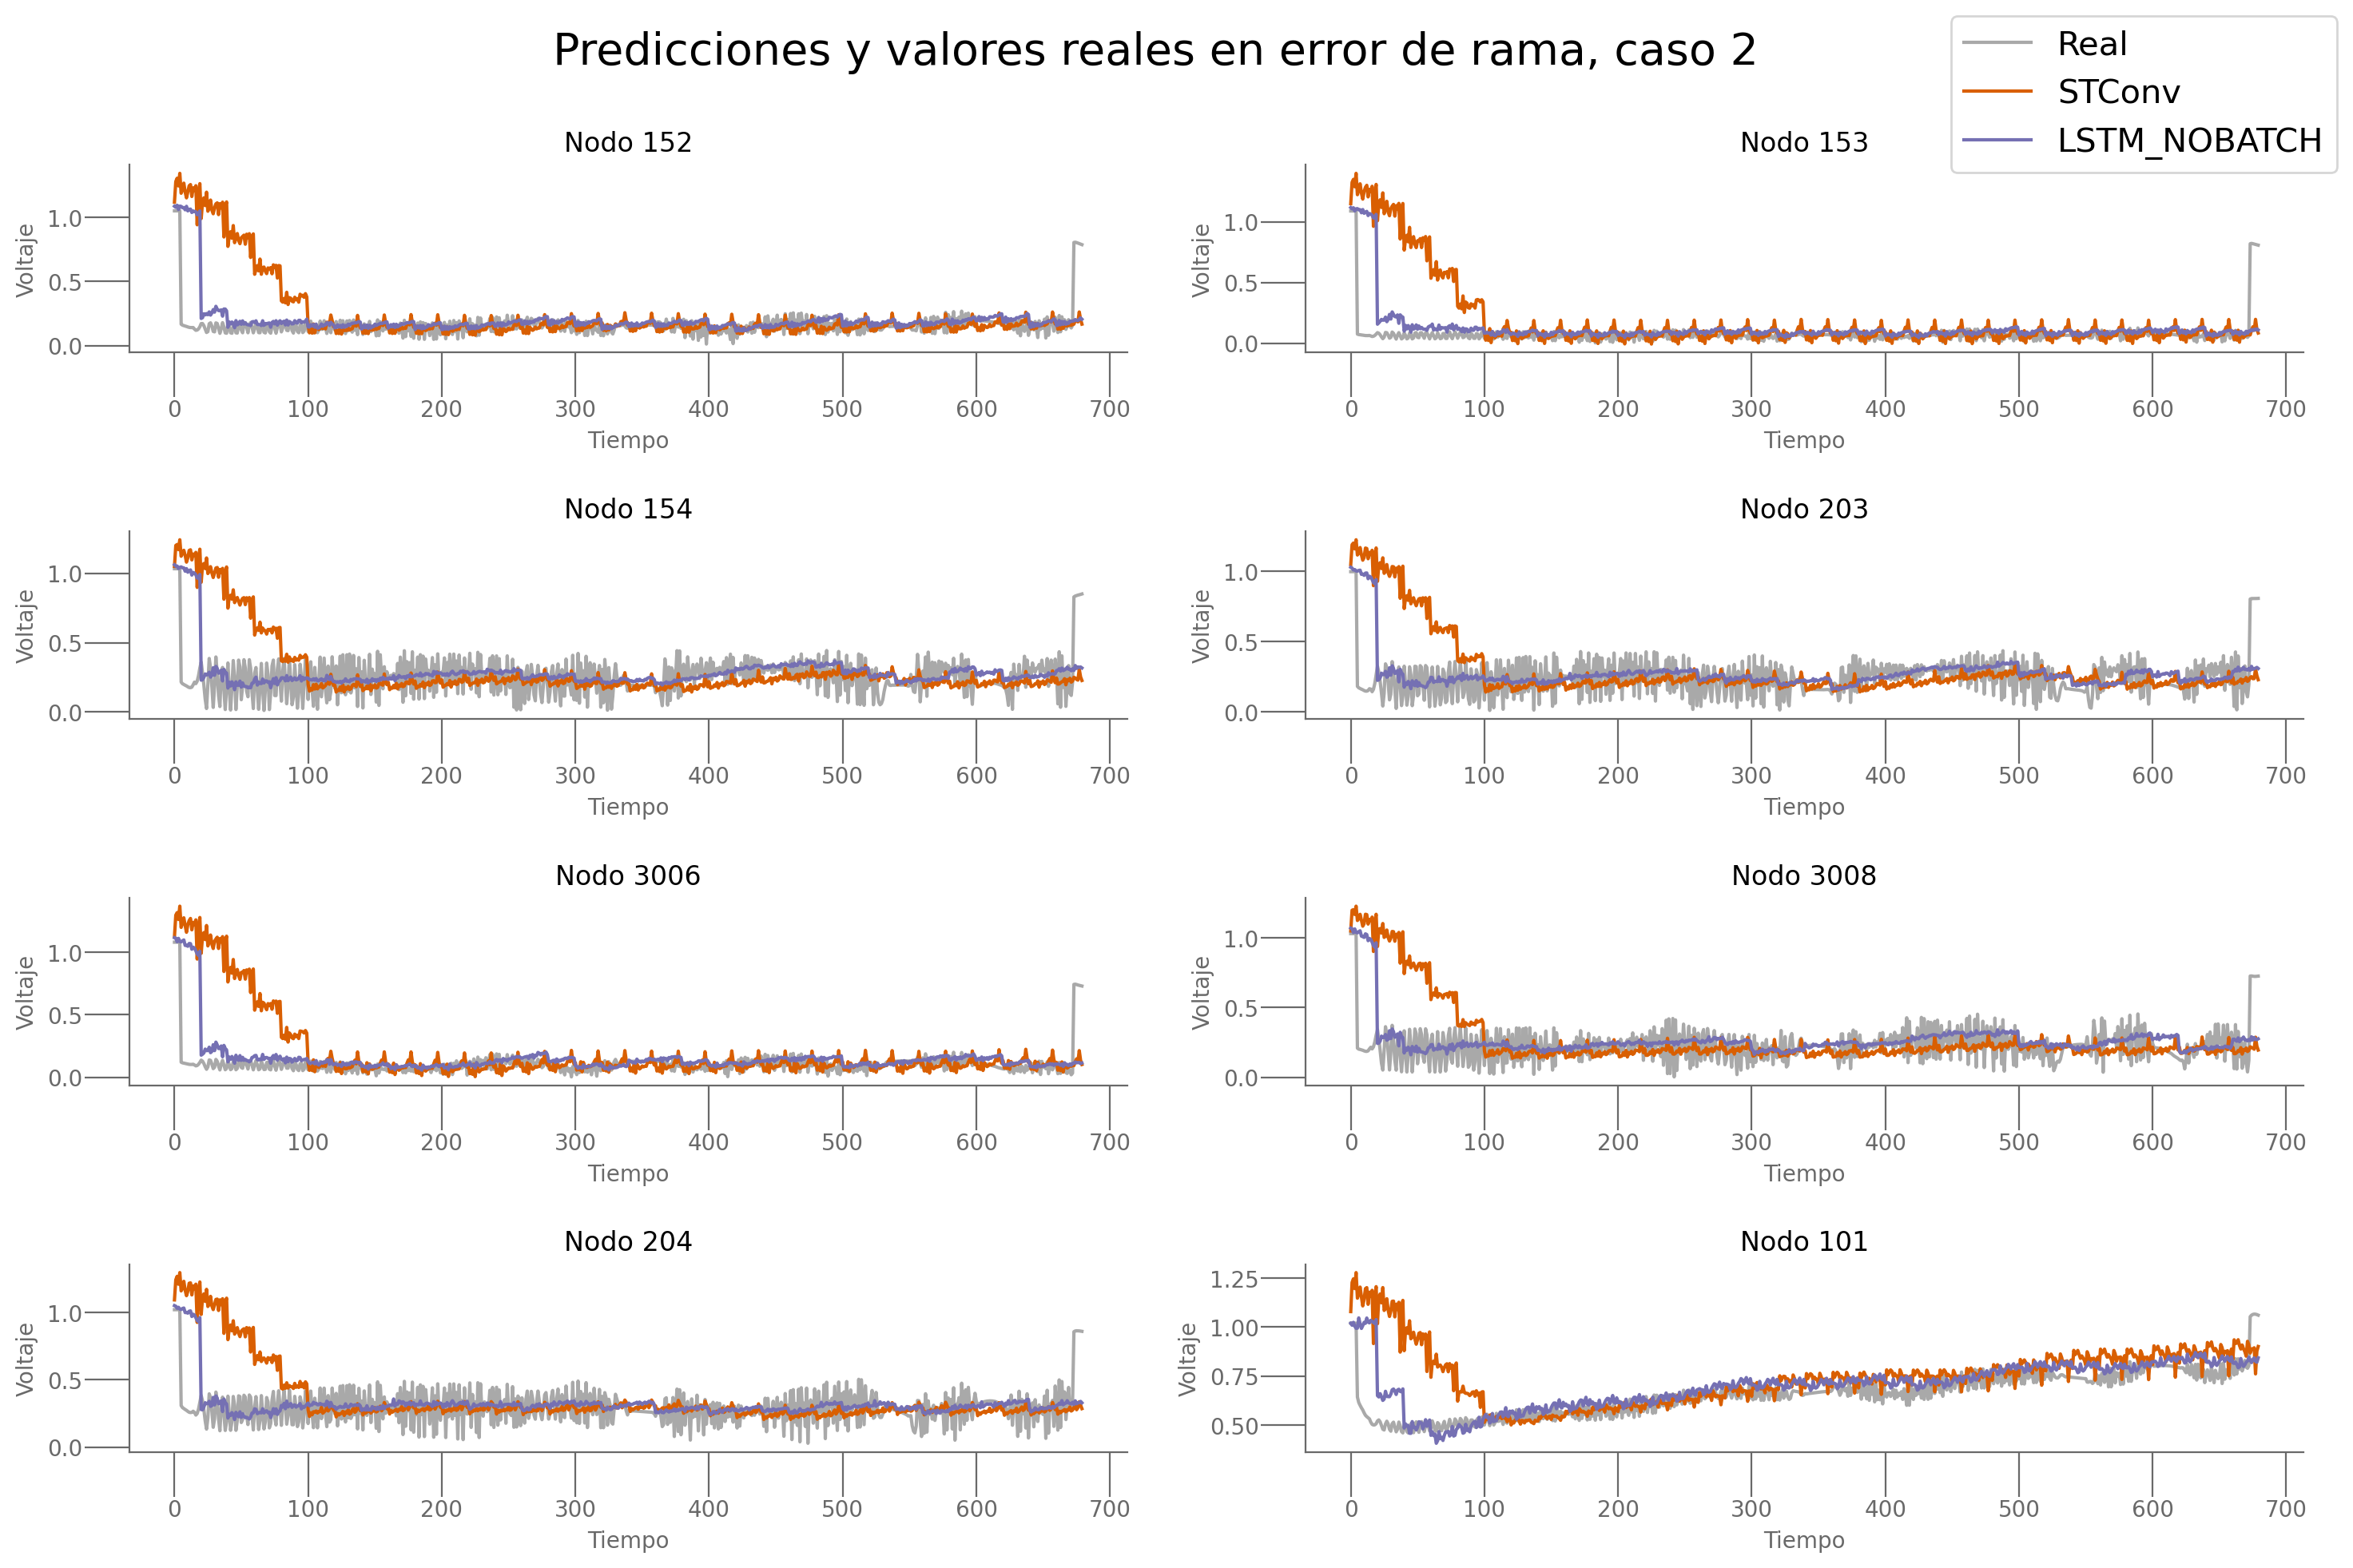

[3, 4, 5, 17, 18, 19, 12, 2]


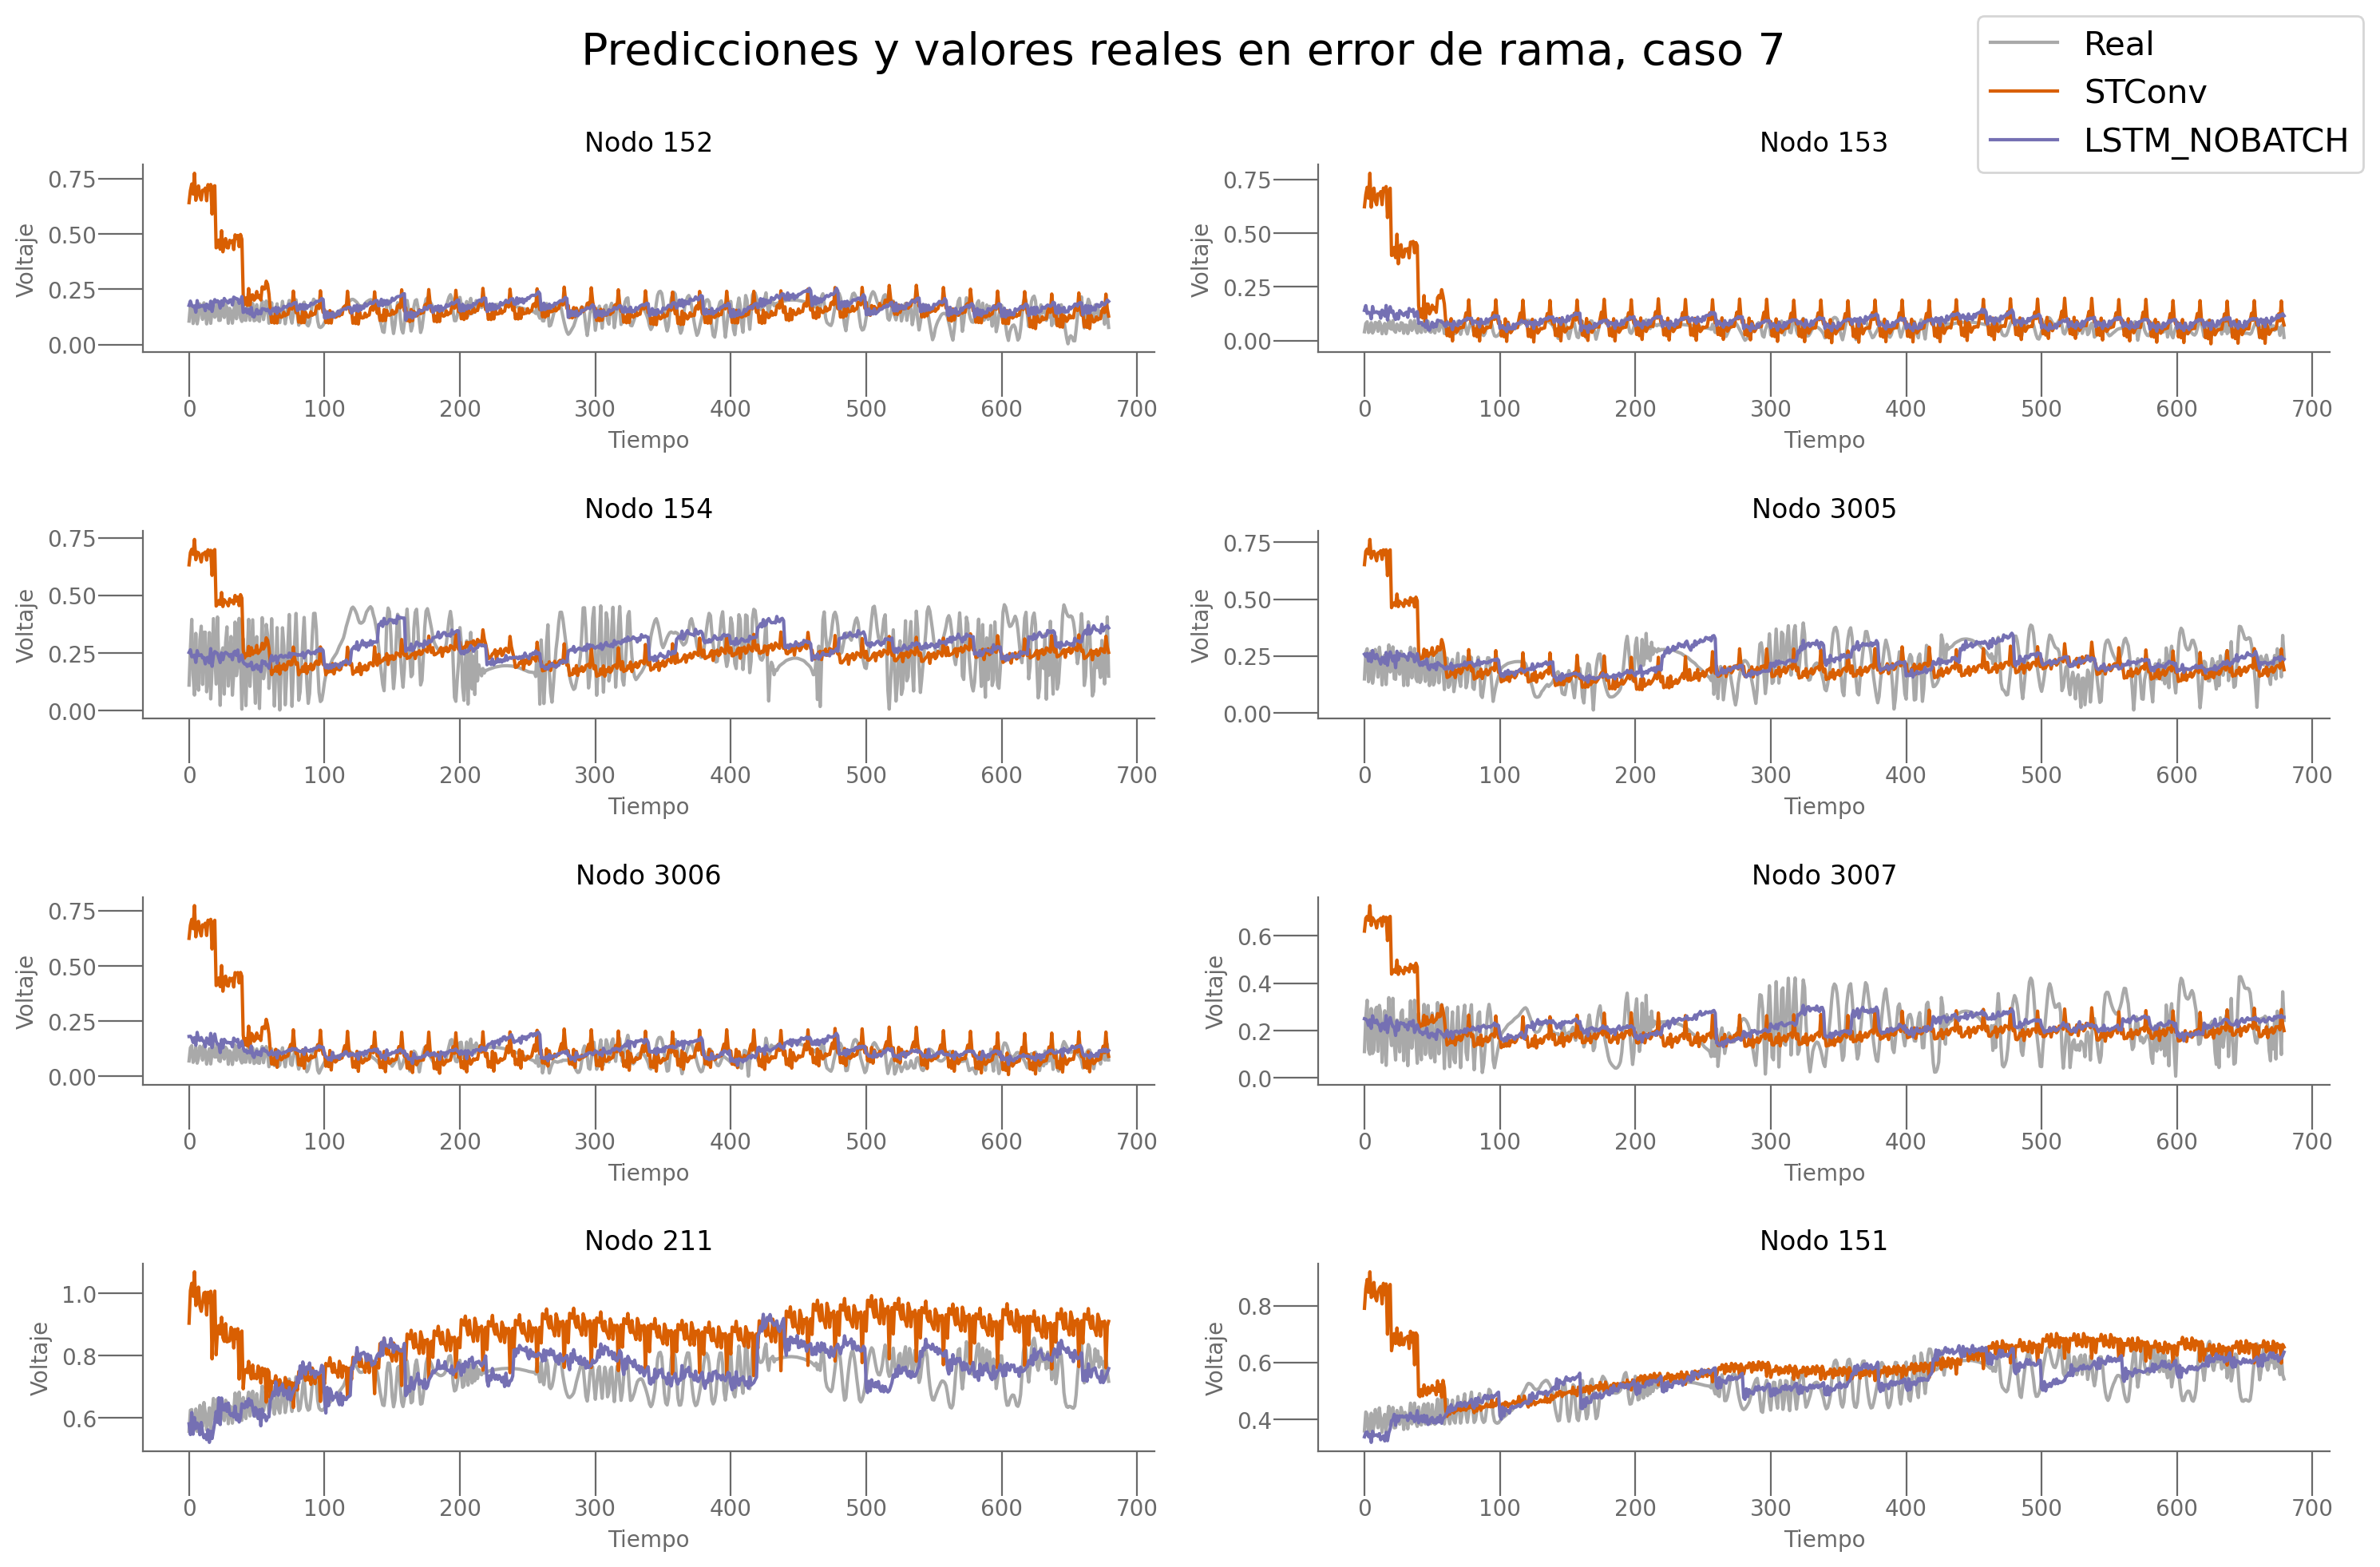

In [10]:
problems = ["gen_trip", "bus_trip", "bus_fault", "branch_fault", "branch_trip"]
p_ess = ['cortocircuito de generador', "cortocircuito de nodo", "error de nodo", "error de rama", "cortocircuito de rama"]
m = "STConv"
i = 3
problem = problems[i]
p_es = p_ess[i]
path = f"/Users/maguado/Documents/UGR/Master/TFM/memoria/resultados/{problem}"

path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)
dataset, situations = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)
n_div_gt = loader.div
dataloader_params = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}

print("Procesando modelo: ", m)
models_analysis = [ m,"LSTM_NOBATCH"] if m != "MSTGCN" else [m, "ASTGCN", "LSTM_NOBATCH"]
predictions = {}
real = {} #Si todos los modelos van sin batch, no hace falta guarsar todos, pero lo ponemos por si acaso
for model_name in models_analysis:
    print("\n\nModelo: ", model_name)
    trainer = process_model(model_name, path_problem_results, dataset, dataloader_params, problem)
    _,_,_,preds, reals = trainer.test()
    predictions[model_name] = preds
    real[model_name] = reals
predictions_list= [value for value in predictions.values()]
real_list = [value for value in real.values()]
num_situations_test = int(len(trainer.loader['test'])/n_div_gt)

fig = plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=2, n_div=n_div_gt, problem=p_es, names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])
plt.savefig(path + f"/{m}_2.png")
plt.show()

fig = plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=7, n_div=n_div_gt, problem=p_es, names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])
plt.savefig(path + f"/{m}_7.png")
plt.show()


In [9]:
models_2 = ["AGCRN", "DyGrEncoder", "MSTGCN", "MPNN_LSTM", "DCRNN", "MTGNN", "EvolveGCN"]
print("Problema: ", problem)
p_es = "cortocircuito de rama"
path = f"/Users/maguado/Documents/UGR/Master/TFM/memoria/resultados/{problem}"
for m in models_2:
    print("Procesando modelo: ", m)
    models_analysis = [ m,"LSTM_NOBATCH"] if m != "MSTGCN" else [m, "ASTGCN", "LSTM_NOBATCH"]
    predictions = {}
    real = {} #Si todos los modelos van sin batch, no hace falta guarsar todos, pero lo ponemos por si acaso
    for model_name in models_analysis:
        print("\n\nModelo: ", model_name)
        trainer = process_model(model_name, path_problem_results, dataset, dataloader_params, problem)
        _,_,_,preds, reals = trainer.test()
        predictions[model_name] = preds
        real[model_name] = reals

    from importlib import reload

    utils_graph =reload(utils.utils_graph)
    from utils.utils_graph import plot_predictions, plot_multiple_models
    

    predictions_list= [value for value in predictions.values()]
    real_list = [value for value in real.values()]
    num_situations_test = int(len(trainer.loader['test'])/n_div_gt)

    fig = plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=2, n_div=n_div_gt, problem=p_es, names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])
    plt.savefig(path + f"/{m}_2.png")
    plt.show()

    fig = plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=7, n_div=n_div_gt, problem=p_es, names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])
    plt.savefig(path + f"/{m}_7.png")
    plt.show()

Problema:  clasificacion
Procesando modelo:  AGCRN


Modelo:  AGCRN


NameError: name 'dataset' is not defined

In [ ]:
nb_block=1, k=2, nb_chev_filter = 4, nb_time_filter =4, time_strides = 2, hidden_size=20)

### Modelo único

In [14]:
model_name = "MPNN_LSTM" #MPNN_LSTM, AGCRN, LSTM, DyGrEncoder
trainer = trainer = process_model(model_name, path_problem_results, dataset, dataloader_params)
_,_,_,preds, reals = trainer.test()



==================== TEST INFO ===================

preds:  (1, 23, 20)
test loss: 0.045889, test r2score -18.247558


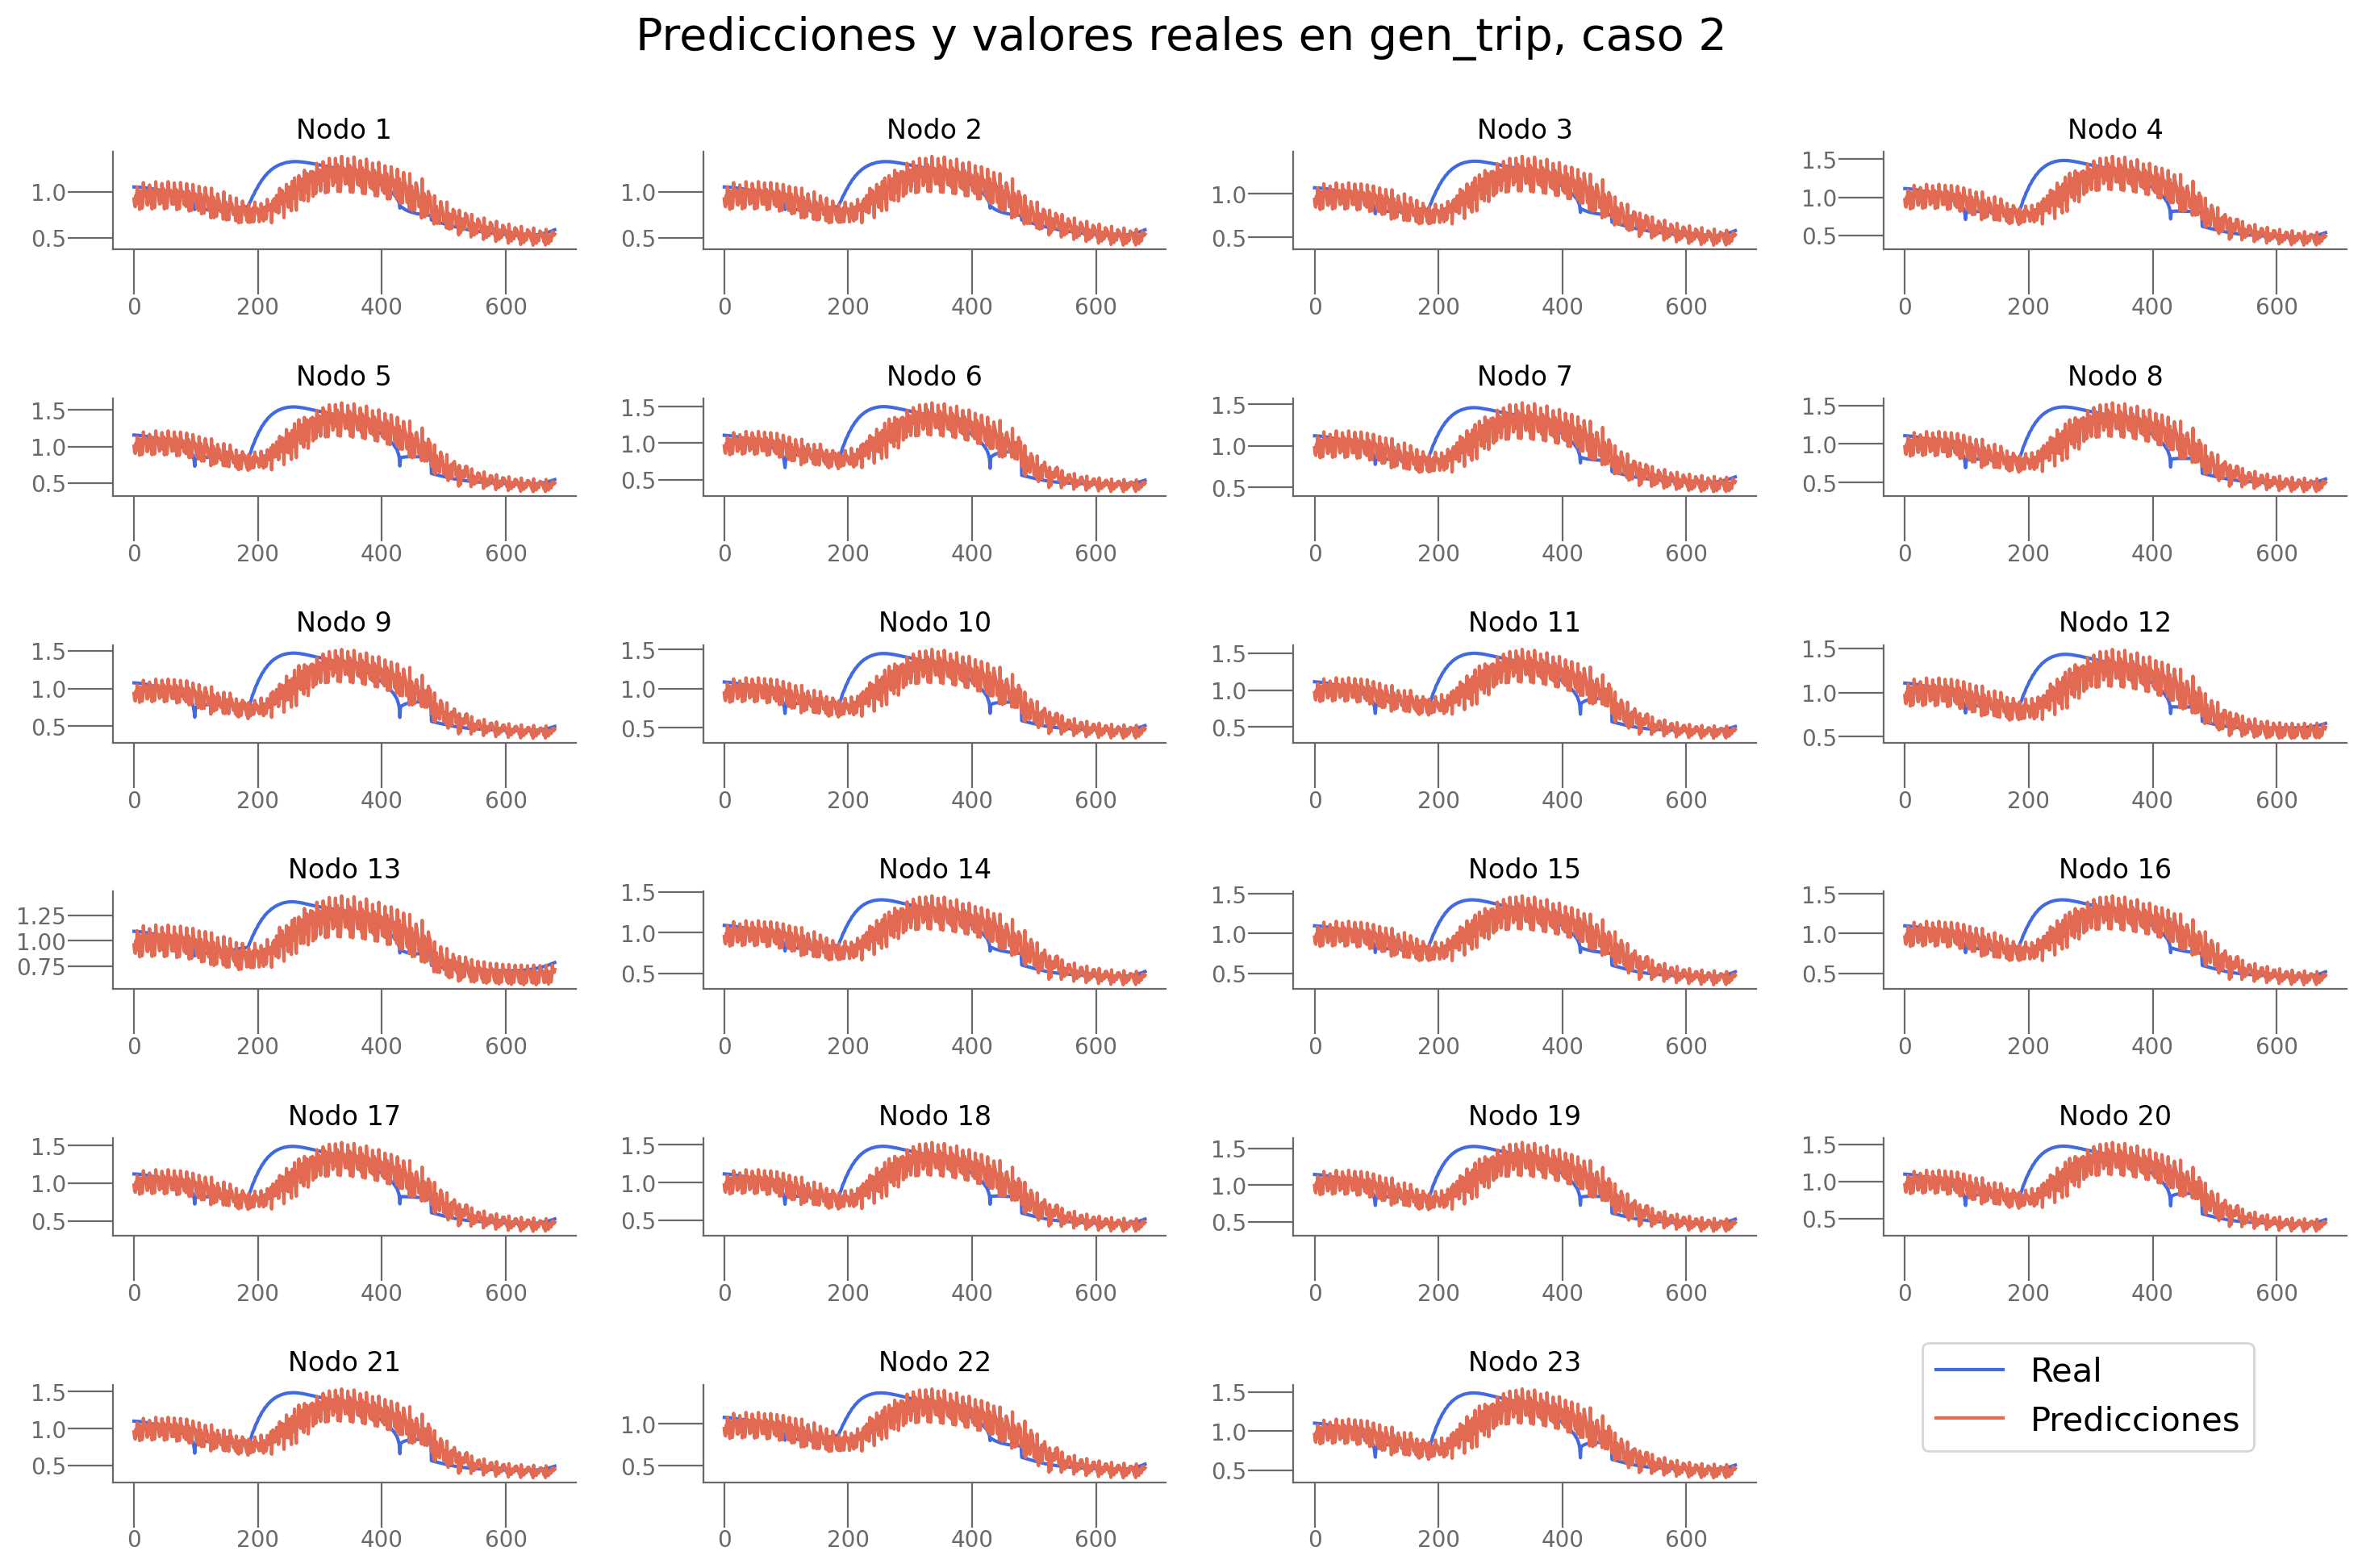

In [15]:
plot_predictions(preds,reals,  n_target=dataset.targets[0].shape[1], n_situation=2, n_div=n_div_gt, problem=problem)

## Comparación Clasificación

In [149]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="classification_type")
_,_,_ =loader.process()
limit = 300
dataset_full, situations_each = loader.get_dataset()
target_names = loader.target_names

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

In [137]:
from importlib import reload
utils_graph =reload(utils.utils_graph)
from utils.utils_graph import plot_clasificacion

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
    
import itertools

In [156]:
name = "MTGNN"
n_nodes =dataset.features[0].shape[0]
n_target = dataset.targets[0].shape[1]
n_features = dataset[0].x.shape[1]
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

df = pd.read_csv(os.path.join(path_problem_results, "results.csv"))
if name not in df['Modelo'].values:
    raise ValueError("Modelo no tiene resultados en el directorio de resultados")
params_prelim = df[df['Modelo']==name]['Params'].values[0]
try:
    params = ast.literal_eval(params_prelim) if isinstance(params_prelim, str) else {}
except ValueError:
    params = {}
print(params)

print(os.path.join(path_problem_results, f"{name}.pt"))
device =  torch.device("cpu")
model = utils.models.MTGNNModel(
                name="MTGNN", 
                node_count=n_nodes, 
                node_features=n_features, 
                n_target=n_target,
                conv_channels=params["conv_channels"],
                residual_channels=params["conv_channels"], 
                out_channels=params["out_channels"],
                skip_channels=params["conv_channels"] // 2, 
                end_channels=n_target, 
                gcn_depth=params["gcn_depth"],
                kernel_size=params["kernel_size"],
                dropout=params["dropout"],
                gcn_true=params["gcn_true"],
                build_adj=params["build_adj"],
                propalpha=params["propalpha"]
            , is_classification=True)
model.load_state_dict(torch.load("/Users/maguado/Documents/UGR/Master/TFM/repo/GNNs_PowerGraph/TFM/experimentos_split/results/clasificacion/MTGNN.pt"))



{'gcn_depth': 2, 'conv_channels': 16, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16}
../experimentos_split/results/clasificacion/MTGNN.pt


RuntimeError: Error(s) in loading state_dict for MTGNNModel:
	size mismatch for recurrent._mtgnn_layers.0._skip_conv.weight: copying a param with shape torch.Size([8, 16, 1, 798]) from checkpoint, the shape in current model is torch.Size([8, 16, 1, 98]).
	size mismatch for recurrent._mtgnn_layers.0._normalization._weight: copying a param with shape torch.Size([16, 23, 798]) from checkpoint, the shape in current model is torch.Size([16, 23, 98]).
	size mismatch for recurrent._mtgnn_layers.0._normalization._bias: copying a param with shape torch.Size([16, 23, 798]) from checkpoint, the shape in current model is torch.Size([16, 23, 98]).
	size mismatch for recurrent._mtgnn_layers.1._skip_conv.weight: copying a param with shape torch.Size([8, 16, 1, 796]) from checkpoint, the shape in current model is torch.Size([8, 16, 1, 96]).
	size mismatch for recurrent._mtgnn_layers.1._normalization._weight: copying a param with shape torch.Size([16, 23, 796]) from checkpoint, the shape in current model is torch.Size([16, 23, 96]).
	size mismatch for recurrent._mtgnn_layers.1._normalization._bias: copying a param with shape torch.Size([16, 23, 796]) from checkpoint, the shape in current model is torch.Size([16, 23, 96]).
	size mismatch for recurrent._skip_conv_0.weight: copying a param with shape torch.Size([8, 1, 1, 800]) from checkpoint, the shape in current model is torch.Size([8, 1, 1, 100]).
	size mismatch for recurrent._skip_conv_E.weight: copying a param with shape torch.Size([8, 16, 1, 796]) from checkpoint, the shape in current model is torch.Size([8, 16, 1, 96]).
	size mismatch for recurrent._end_conv_1.weight: copying a param with shape torch.Size([5, 8, 1, 1]) from checkpoint, the shape in current model is torch.Size([20, 8, 1, 1]).
	size mismatch for recurrent._end_conv_1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for recurrent._end_conv_2.weight: copying a param with shape torch.Size([16, 5, 1, 1]) from checkpoint, the shape in current model is torch.Size([16, 20, 1, 1]).
	size mismatch for linear.weight: copying a param with shape torch.Size([5, 16]) from checkpoint, the shape in current model is torch.Size([20, 16]).
	size mismatch for linear.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([20]).

In [148]:
problem ="clasificacion"
models_2 = ["AGCRN", "DyGrEncoder", "MSTGCN", "MPNN_LSTM", "DCRNN", "MTGNN", "EvolveGCN"]
print("Problema: ", problem)

path = f"/Users/maguado/Documents/UGR/Master/TFM/memoria/resultados/{problem}"
for m in models_2:
    try:
        print("Procesando modelo: ", m)
        
        print("\n\nModelo: ", m)
        trainer = process_model(m, path_problem_results, dataset, dataloader_params, problem, is_classification=True)
        _,_,_,preds, reals = trainer.test()
        fig = plot_clasificacion(real, preds, target_names, m)


        plt.savefig(path)
        plt.show()
    except:
        
        print(f"Error en {m}")

Problema:  clasificacion
Procesando modelo:  AGCRN


Modelo:  AGCRN
{'hidden': 50, 'embedding': 5, 'K': 2}
../experimentos_split/results/clasificacion/AGCRN.pt
Error en AGCRN
Procesando modelo:  DyGrEncoder


Modelo:  DyGrEncoder
{'aggr': 'mean', 'conv': 2, 'lstm': 1, 'lstm_out': 900}
../experimentos_split/results/clasificacion/DyGrEncoder.pt
Error en DyGrEncoder
Procesando modelo:  MSTGCN


Modelo:  MSTGCN
{'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_filter': 4, 'time_strides': 2, 'hidden': 80}
../experimentos_split/results/clasificacion/MSTGCN.pt
Error en MSTGCN
Procesando modelo:  MPNN_LSTM


Modelo:  MPNN_LSTM
{'Hidden Size': 64, 'Dropout': 0.2}
../experimentos_split/results/clasificacion/MPNN_LSTM.pt
Error en MPNN_LSTM
Procesando modelo:  DCRNN


Modelo:  DCRNN
{'hidden': 60}
../experimentos_split/results/clasificacion/DCRNN.pt
../experimentos_split/results/clasificacion/DCRNN.pt
Error en DCRNN
Procesando modelo:  MTGNN


Modelo:  MTGNN
{'gcn_depth': 2, 'conv_channels': 16, 'kern

## Tablas de resultados

In [11]:
problem = "branch_trip"
path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)

../experimentos_split/results/branch_trip


In [12]:
df = pd.read_csv(path_problem_results+'/results.csv')
df.sort_values(by='Loss_tst')



,Modelo,Params,Fichero_resultados_experimento,Loss_tst,R2_tst,Loss_nodes,R2_eval,Loss_eval,Loss_final
2,DyGrEncoder,"{'aggr': 'add', 'conv': 1, 'lstm': 2}",./results/branch_trip/ajustes/DryGrEncoder_res...,0.002719,-0.549398,[[0.00075153 0.00100153 0.00117453 0.00137669 ...,-0.486826,0.002425,0.002677
6,ASTGCN,"{'nb_block': 1, 'K': 2, 'nb_chev_filter': 4, '...",NaN,0.003289,-0.984139,[0.00142264 0.00111268 0.00193647 0.0036899 0...,-0.821554,0.003008,0.003370
7,DCRNN,{'hidden': 60},./results/branch_trip/ajustes/DCRNN_results.csv,0.003512,-1.369519,[0.00239086 0.00207138 0.0026651 0.00374208 0...,-1.325023,0.003597,0.003779
0,LSTM,NaN,NaN,0.003700,0.398922,[0.0036937 0.00202668 0.00244704 0.00374463 0...,0.435549,0.003684,0.003296
8,MTGNN,"{'gcn_depth': 2, 'conv_channels': 8, 'kernel_s...",../results/branch_trip/ajustes/MTGNN_results.csv,0.003772,-0.503625,[[0.00123794 0.00367469 0.00154344 0.00309896 ...,-0.083005,0.004229,0.006137
4,MSTGCN,"{'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...",./results/branch_trip/ajustes/MSTGCN_results.csv,0.004047,-1.404772,[0.00195064 0.00158103 0.0026879 0.00473193 0...,-1.172420,0.003606,0.003641
3,MPNN_LSTM,"{'hidden_size': 32, 'dropout': 0.8}",./results/branch_trip/ajustes/MPNNLSTM_results...,0.004205,-1.453302,[[0.00172821 0.00195926 0.00137822 0.00249665 ...,-1.195372,0.003632,0.003865
1,LSTM_NOBATCH,NaN,NaN,0.004787,-1.839737,[0.01389701 0.00177465 0.00324512 0.0049619 0...,-1.577386,0.004085,0.004827
9,AGCRN,"{'hidden': 10, 'K': 2, 'embedding': 3}",./results/branch_trip/ajustes/AGCRN_results.csv,0.006657,-0.324354,[0.00697844 0.00445916 0.01291979 0.00432548 0...,-0.160016,0.006265,0.005491
10,STConv,"{'out_channels': 32, 'kernel_size': 5, 'hidden...",NaN,0.036503,-18.098037,[0.02419574 0.02065325 0.0284658 0.0418549 0...,-16.633463,0.035034,0.031335


In [197]:
df['Loss_final'] = df.apply(lambda row: row['loss_final'] if row['Loss_final'] == 0.0000 else row['Loss_final'], axis=1)
df['R2_eval'] = df.apply(lambda row: row['r2_eval_final'] if row['R2_eval'] == 0.0000 else row['R2_eval'], axis=1)
df['Loss_eval'] = df.apply(lambda row: row['loss_eval_final'] if row['Loss_eval'] == 0.0000 else row['Loss_eval'], axis=1)
df.drop(columns=['loss_final', 'r2_eval_final', 'loss_eval_final'], inplace=True)

### Comparación general regresión


In [13]:
inverse_transformation_dict = {v: k for k, v in loader.transformation_dict.items()}

In [14]:
path_problem_results

'../experimentos_split/results/branch_trip'

#### Solución problema nodos

In [15]:
df = pd.read_csv(path_problem_results+'/results.csv')

df.set_index("Modelo", inplace=True)
loss_per_node = df[['Loss_nodes']]
loss_per_node['Loss_nodes'] = loss_per_node['Loss_nodes'].apply(lambda x: [i for i in x.replace("[", "").replace("]", "").replace("\n", " ").replace(",", "").split(" ") if i])

loss_per_node['len']=loss_per_node['Loss_nodes'].apply(lambda x: len(x))
loss_per_node

/var/folders/bj/wg2_mprn1fl8bf0h7tq_sh2c0000gn/T/ipykernel_12626/2848822682.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_per_node['Loss_nodes'] = loss_per_node['Loss_nodes'].apply(lambda x: [i for i in x.replace("[", "").replace("]", "").replace("\n", " ").replace(",", "").split(" ") if i])
/var/folders/bj/wg2_mprn1fl8bf0h7tq_sh2c0000gn/T/ipykernel_12626/2848822682.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_per_node['len']=loss_per_node['Loss_nodes'].apply(lambda x: len(x))


,Loss_nodes,len
Modelo,,
LSTM,"[0.0036937, 0.00202668, 0.00244704, 0.00374463...",23
LSTM_NOBATCH,"[0.01389701, 0.00177465, 0.00324512, 0.0049619...",23
DyGrEncoder,"[0.00075153, 0.00100153, 0.00117453, 0.0013766...",20
MPNN_LSTM,"[0.00172821, 0.00195926, 0.00137822, 0.0024966...",20
MSTGCN,"[0.00195064, 0.00158103, 0.0026879, 0.00473193...",23
EvolveGCN,"[0.02897943, 0.02597875, 0.02557625, 0.0541741...",23
ASTGCN,"[0.00142264, 0.00111268, 0.00193647, 0.0036899...",23
DCRNN,"[0.00239086, 0.00207138, 0.0026651, 0.00374208...",23
MTGNN,"[0.00123794, 0.00367469, 0.00154344, 0.0030989...",20


In [16]:
problem = "branch_trip"
path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)
dataset, situations = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)

n_div_gt = loader.div


../experimentos_split/results/branch_trip
Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [21]:
model_name ='MTGNN'
dataloader_params = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":False
}
predictions = {}
real = {} #Si todos los modelos van sin batch, no hace falta guarsar todos, pero lo ponemos por si acaso
print("\n\nModelo: ", model_name)
trainer = process_model(model_name, path_problem_results, dataset, dataloader_params, problem)
_,_,loss_nodes,preds, reals = trainer.test()



Modelo:  MTGNN
{'gcn_depth': 2, 'conv_channels': 8, 'kernel_size': 3, 'dropout': 0.25, 'gcn_true': True, 'build_adj': True, 'propalpha': 0.15, 'out_channels': 16}
../experimentos_split/results/branch_trip/MTGNN.pt

==================== TEST INFO ===================

test loss: 0.004328, test R2 score: -1.202163


In [22]:
np.mean(loss_nodes, axis=0)

array([0.00241523, 0.00201787, 0.00303136, 0.00489873, 0.00564012,
       0.00646065, 0.00360156, 0.00525135, 0.00642992, 0.00475986,
       0.00627596, 0.00403555, 0.00210768, 0.00306443, 0.00344519,
       0.00360932, 0.00475396, 0.00479367, 0.00540779, 0.00526634,
       0.00568243, 0.00253355, 0.00407069], dtype=float32)

#### Continuación

In [23]:
df = pd.read_csv(path_problem_results+'/results.csv')

df.set_index("Modelo", inplace=True)
loss_per_node = df[['Loss_nodes']]
loss_per_node['Loss_nodes'] = loss_per_node['Loss_nodes'].apply(lambda x: [i for i in x.replace("[", "").replace("]", "").replace("\n", " ").replace(",", "").split(" ") if i])


for i in range(len(loss_per_node['Loss_nodes'][0])):
    node = inverse_transformation_dict[int(i)]
    loss_per_node[f'N{node}'] = loss_per_node['Loss_nodes'].apply(lambda x: float(x[i]))

/var/folders/bj/wg2_mprn1fl8bf0h7tq_sh2c0000gn/T/ipykernel_12626/660632131.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_per_node['Loss_nodes'] = loss_per_node['Loss_nodes'].apply(lambda x: [i for i in x.replace("[", "").replace("]", "").replace("\n", " ").replace(",", "").split(" ") if i])
/var/folders/bj/wg2_mprn1fl8bf0h7tq_sh2c0000gn/T/ipykernel_12626/660632131.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loss_per_node[f'N{node}'] = loss_per_node['Loss_nodes'].apply(lambda x: float(x[i

In [24]:
loss_per_node.drop("Loss_nodes", axis=1, inplace=True)

In [25]:
df.drop(["EvolveGCN"], axis=0, inplace=True)
df.drop("LSTM_NOBATCH", axis=0, inplace=True)

df.drop("STConv", axis=0, inplace=True)


In [26]:
loss_per_node.drop(["EvolveGCN"], axis=0, inplace=True)

loss_per_node.drop(["LSTM_NOBATCH"], axis=0, inplace=True)
loss_per_node.drop(["STConv"], axis=0, inplace=True)



In [27]:

from matplotlib.colors import LinearSegmentedColormap, to_hex

colors = ["#ffe4e1", "#ffccd5", "#ff99aa", "#ff6680", "#b3003b"] 

n_bins = 30  
cmap_name = 'Greens'
cmap=cmap_name
#cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)



In [28]:
path_save = f"/Users/maguado/Documents/UGR/Master/TFM/memoria/resultados/{problem}"

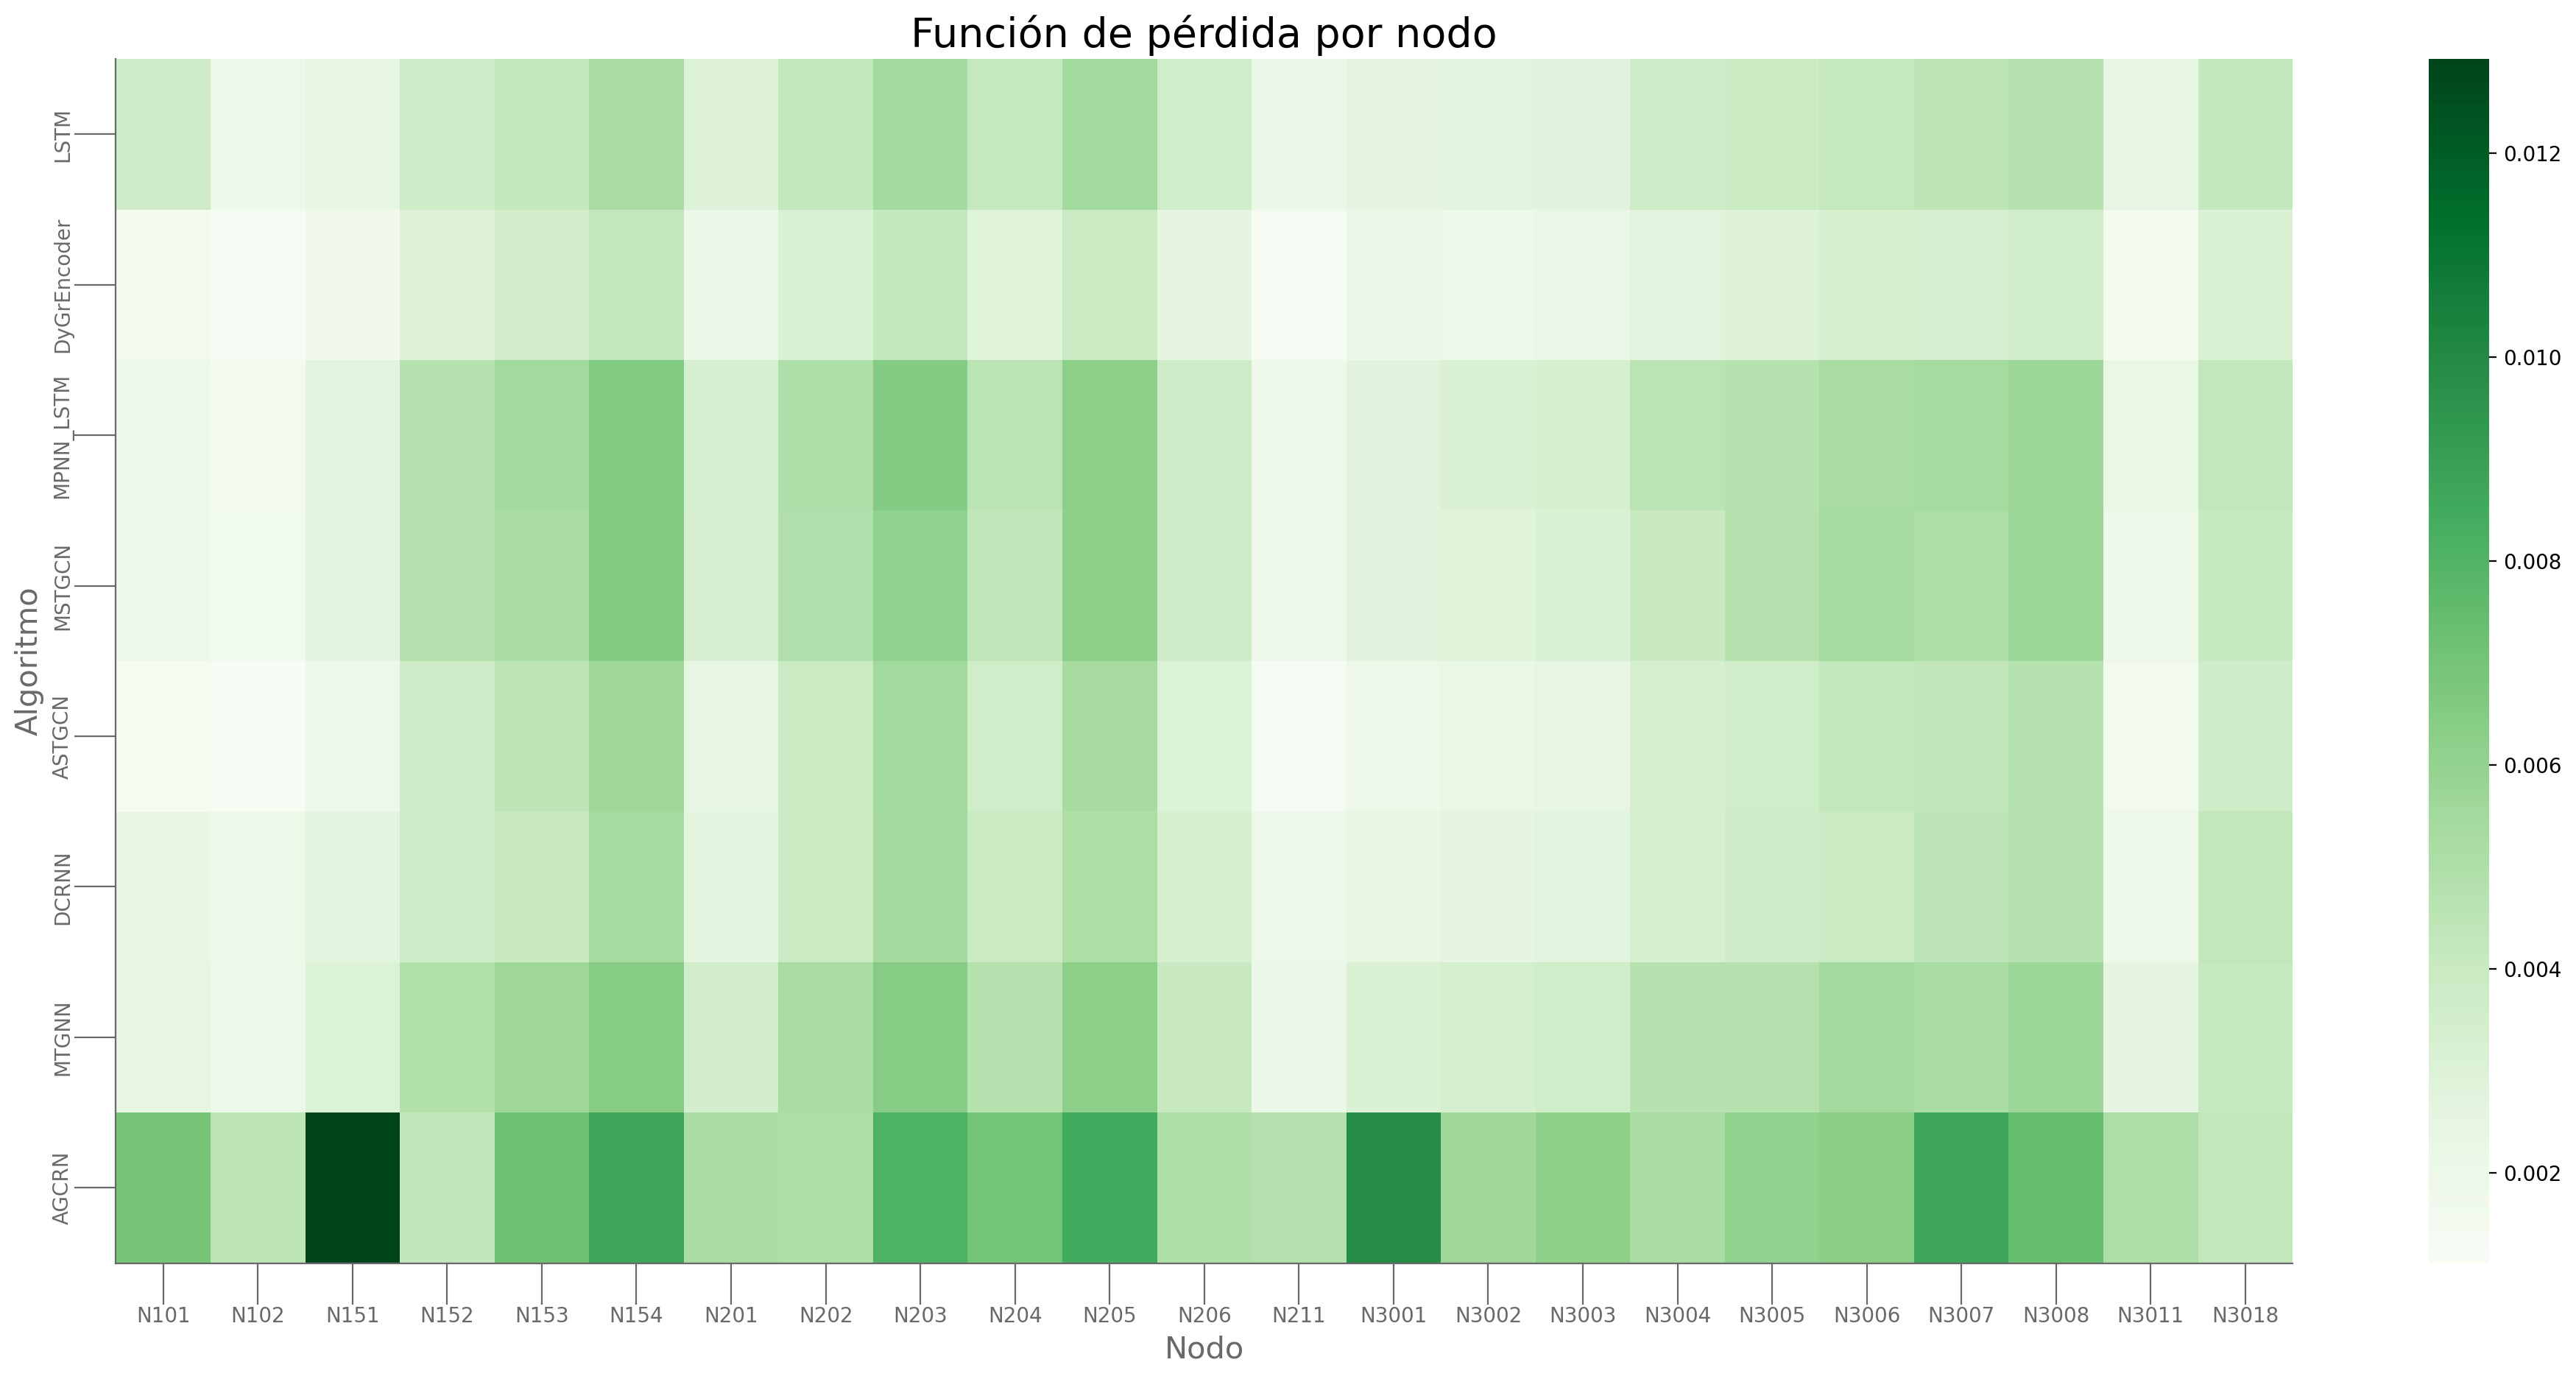

In [29]:
plt.figure(figsize=(20, 10), dpi=200)
ax = plt.gca()
sns.heatmap(loss_per_node, annot=False,  cmap=cmap, ax=ax)
ax.set_xlabel('Nodo', fontsize=15)
ax.set_ylabel('Algoritmo', fontsize=15)
plt.title("Función de pérdida por nodo", fontsize=20)
format_plot(ax)
plt.tight_layout(pad=3)
plt.savefig(path_save+f"/loss_per_node_{str.lower(cmap_name)}.png")

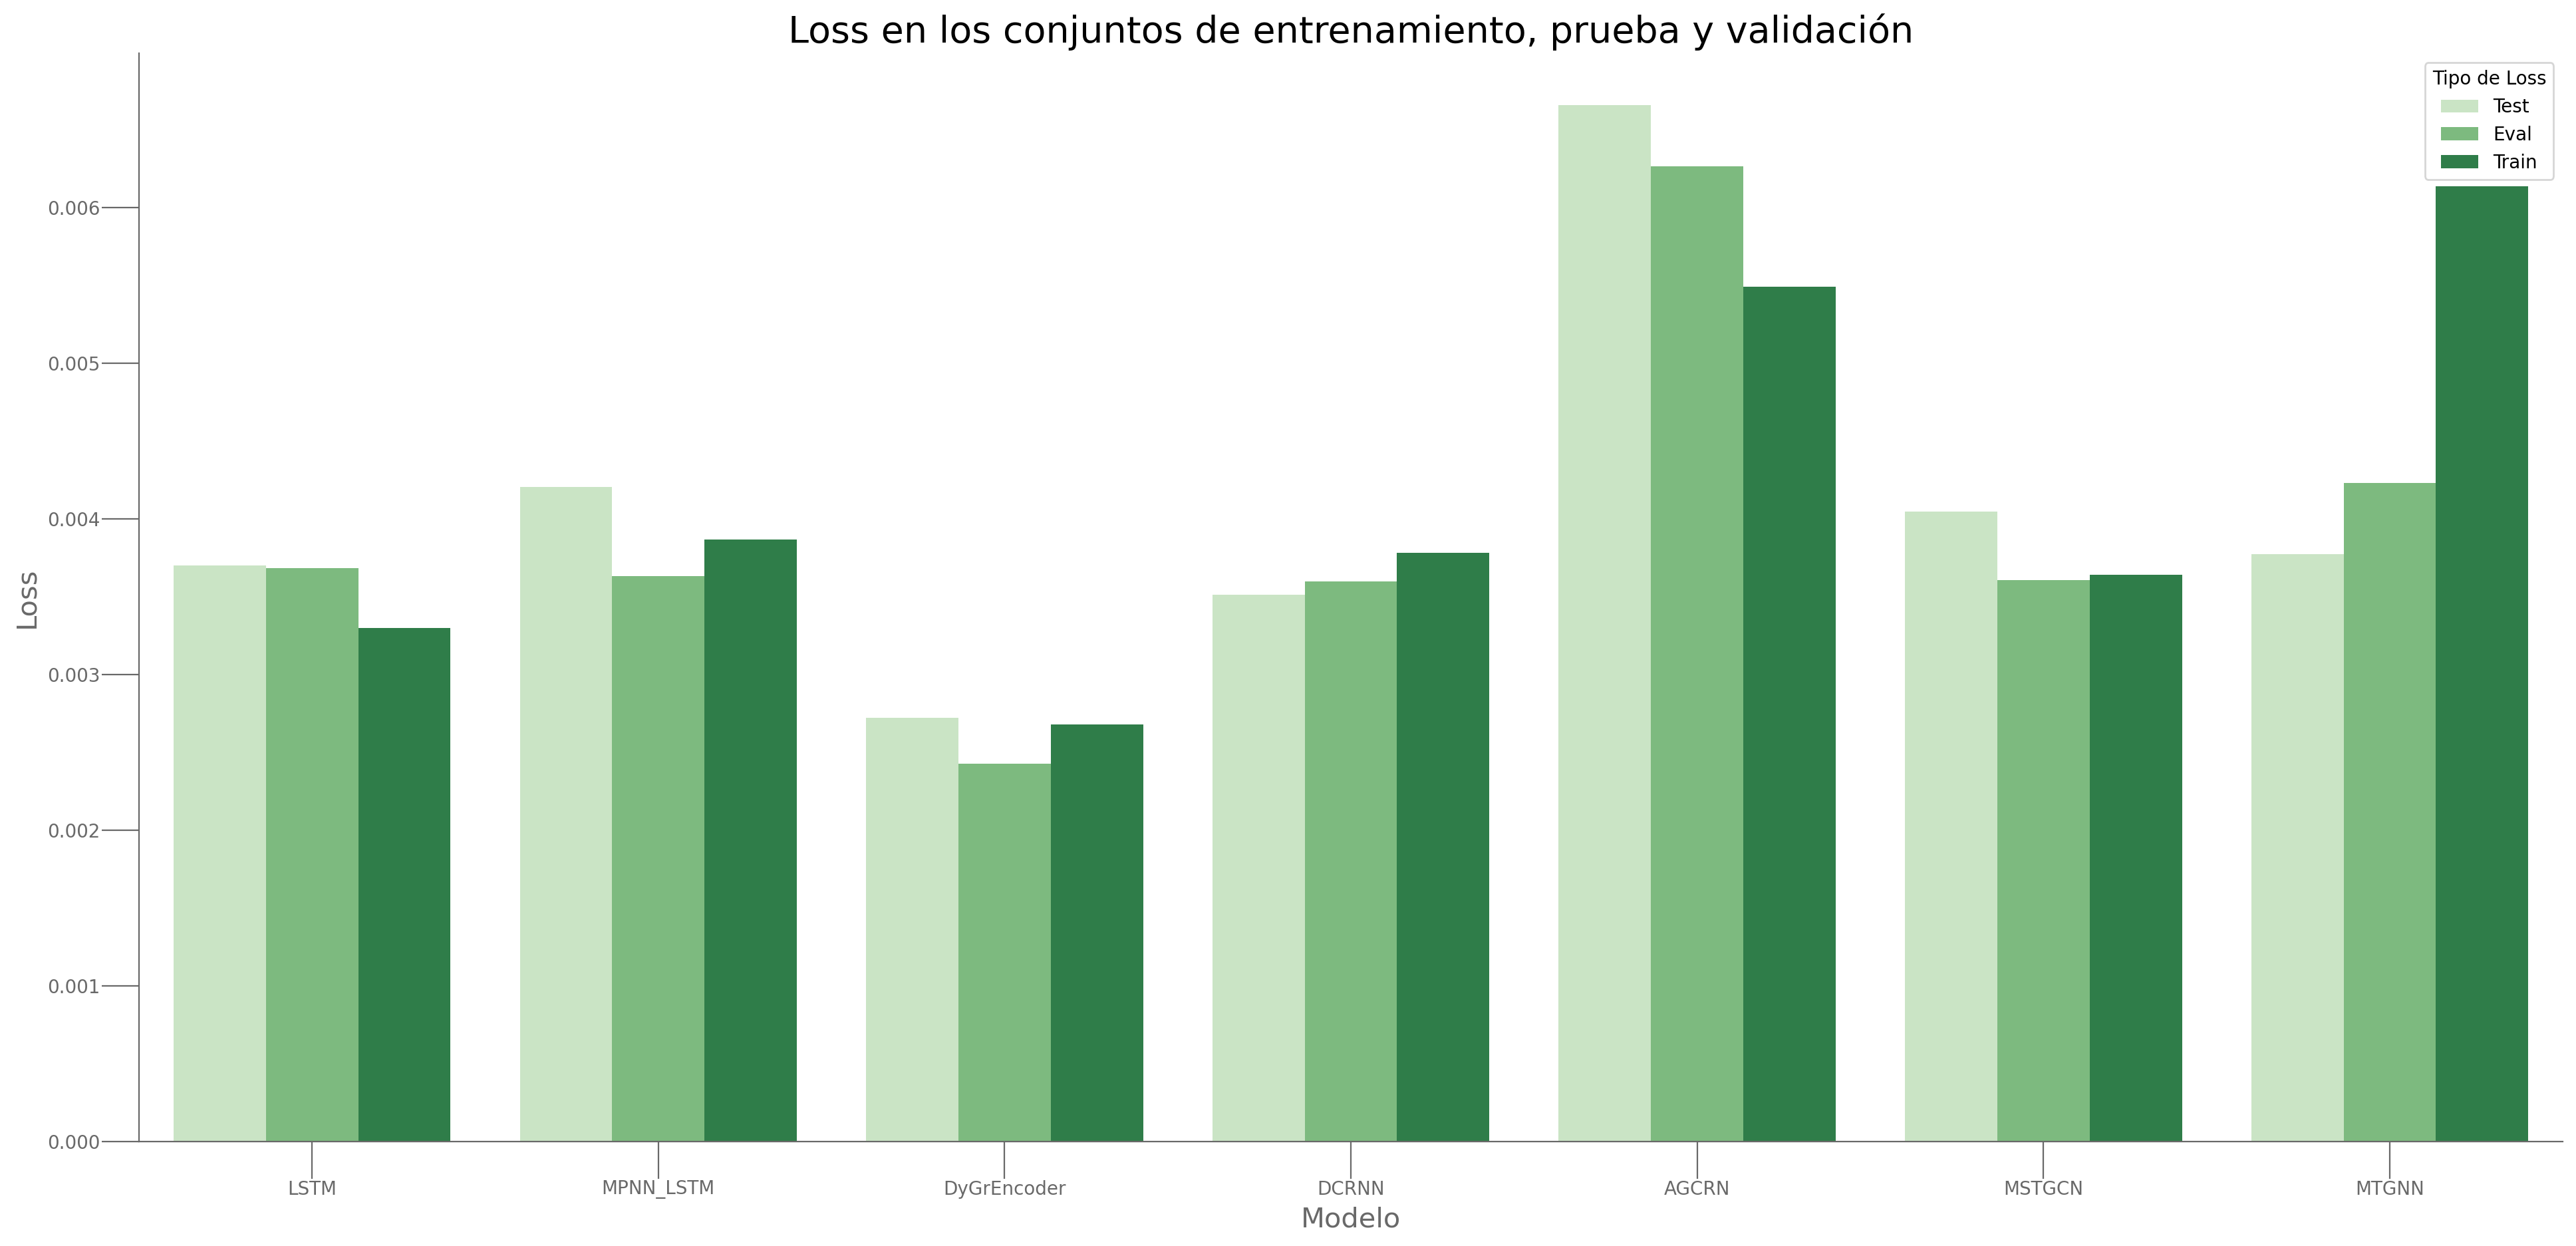

In [30]:
# Seleccionar los modelos deseados
df_p = df.loc[["LSTM", "MPNN_LSTM", "DyGrEncoder", "DCRNN", "AGCRN", "MSTGCN", "MTGNN", "DCRNN"]]

# Renombrar las columnas para las pérdidas
df_p = df_p.rename(columns={'Loss_tst': 'Test', 'Loss_eval': 'Eval', "Loss_final":"Train"})

# Convertir el DataFrame a formato long para las pérdidas
df_long_loss = pd.melt(df_p.reset_index(), id_vars=['Modelo'], value_vars=['Test', 'Eval', "Train"], 
                       var_name='Tipo de Loss', value_name='Valor')


if cmap_name == "rose":
    n_colors = len(df_long_loss['Tipo de Loss'].unique())  # Asumiendo que tienes un df llamado df_long_loss
    palette = [to_hex(cmap(i / n_colors)) for i in range(n_colors)]
else:
    palette = cmap

    
plt.figure(figsize=(20, 10), dpi=200)
ax = plt.gca()
sns.barplot(x='Modelo', y='Valor', data=df_long_loss,hue='Tipo de Loss', ax=ax, palette=palette)
ax.set_xlabel('Modelo', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
plt.title('Loss en los conjuntos de entrenamiento, prueba y validación', fontsize=20)
#ax[1].set_xticklabels(target_names, rotation=45)  # Asegurando que los nombres estén rotados si son largos
format_plot(ax)
plt.tight_layout(pad=3)
plt.savefig(path_save+f"/loss_train_test_eval_{str.lower(cmap_name)}.png")

Modelo con la menor variabilidad: DyGrEncoder (Varianza: 8.479968750703558e-07)


/var/folders/bj/wg2_mprn1fl8bf0h7tq_sh2c0000gn/T/ipykernel_12626/4279610848.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=loss_per_node.index, y='Varianza', data=loss_per_node, palette=palette)


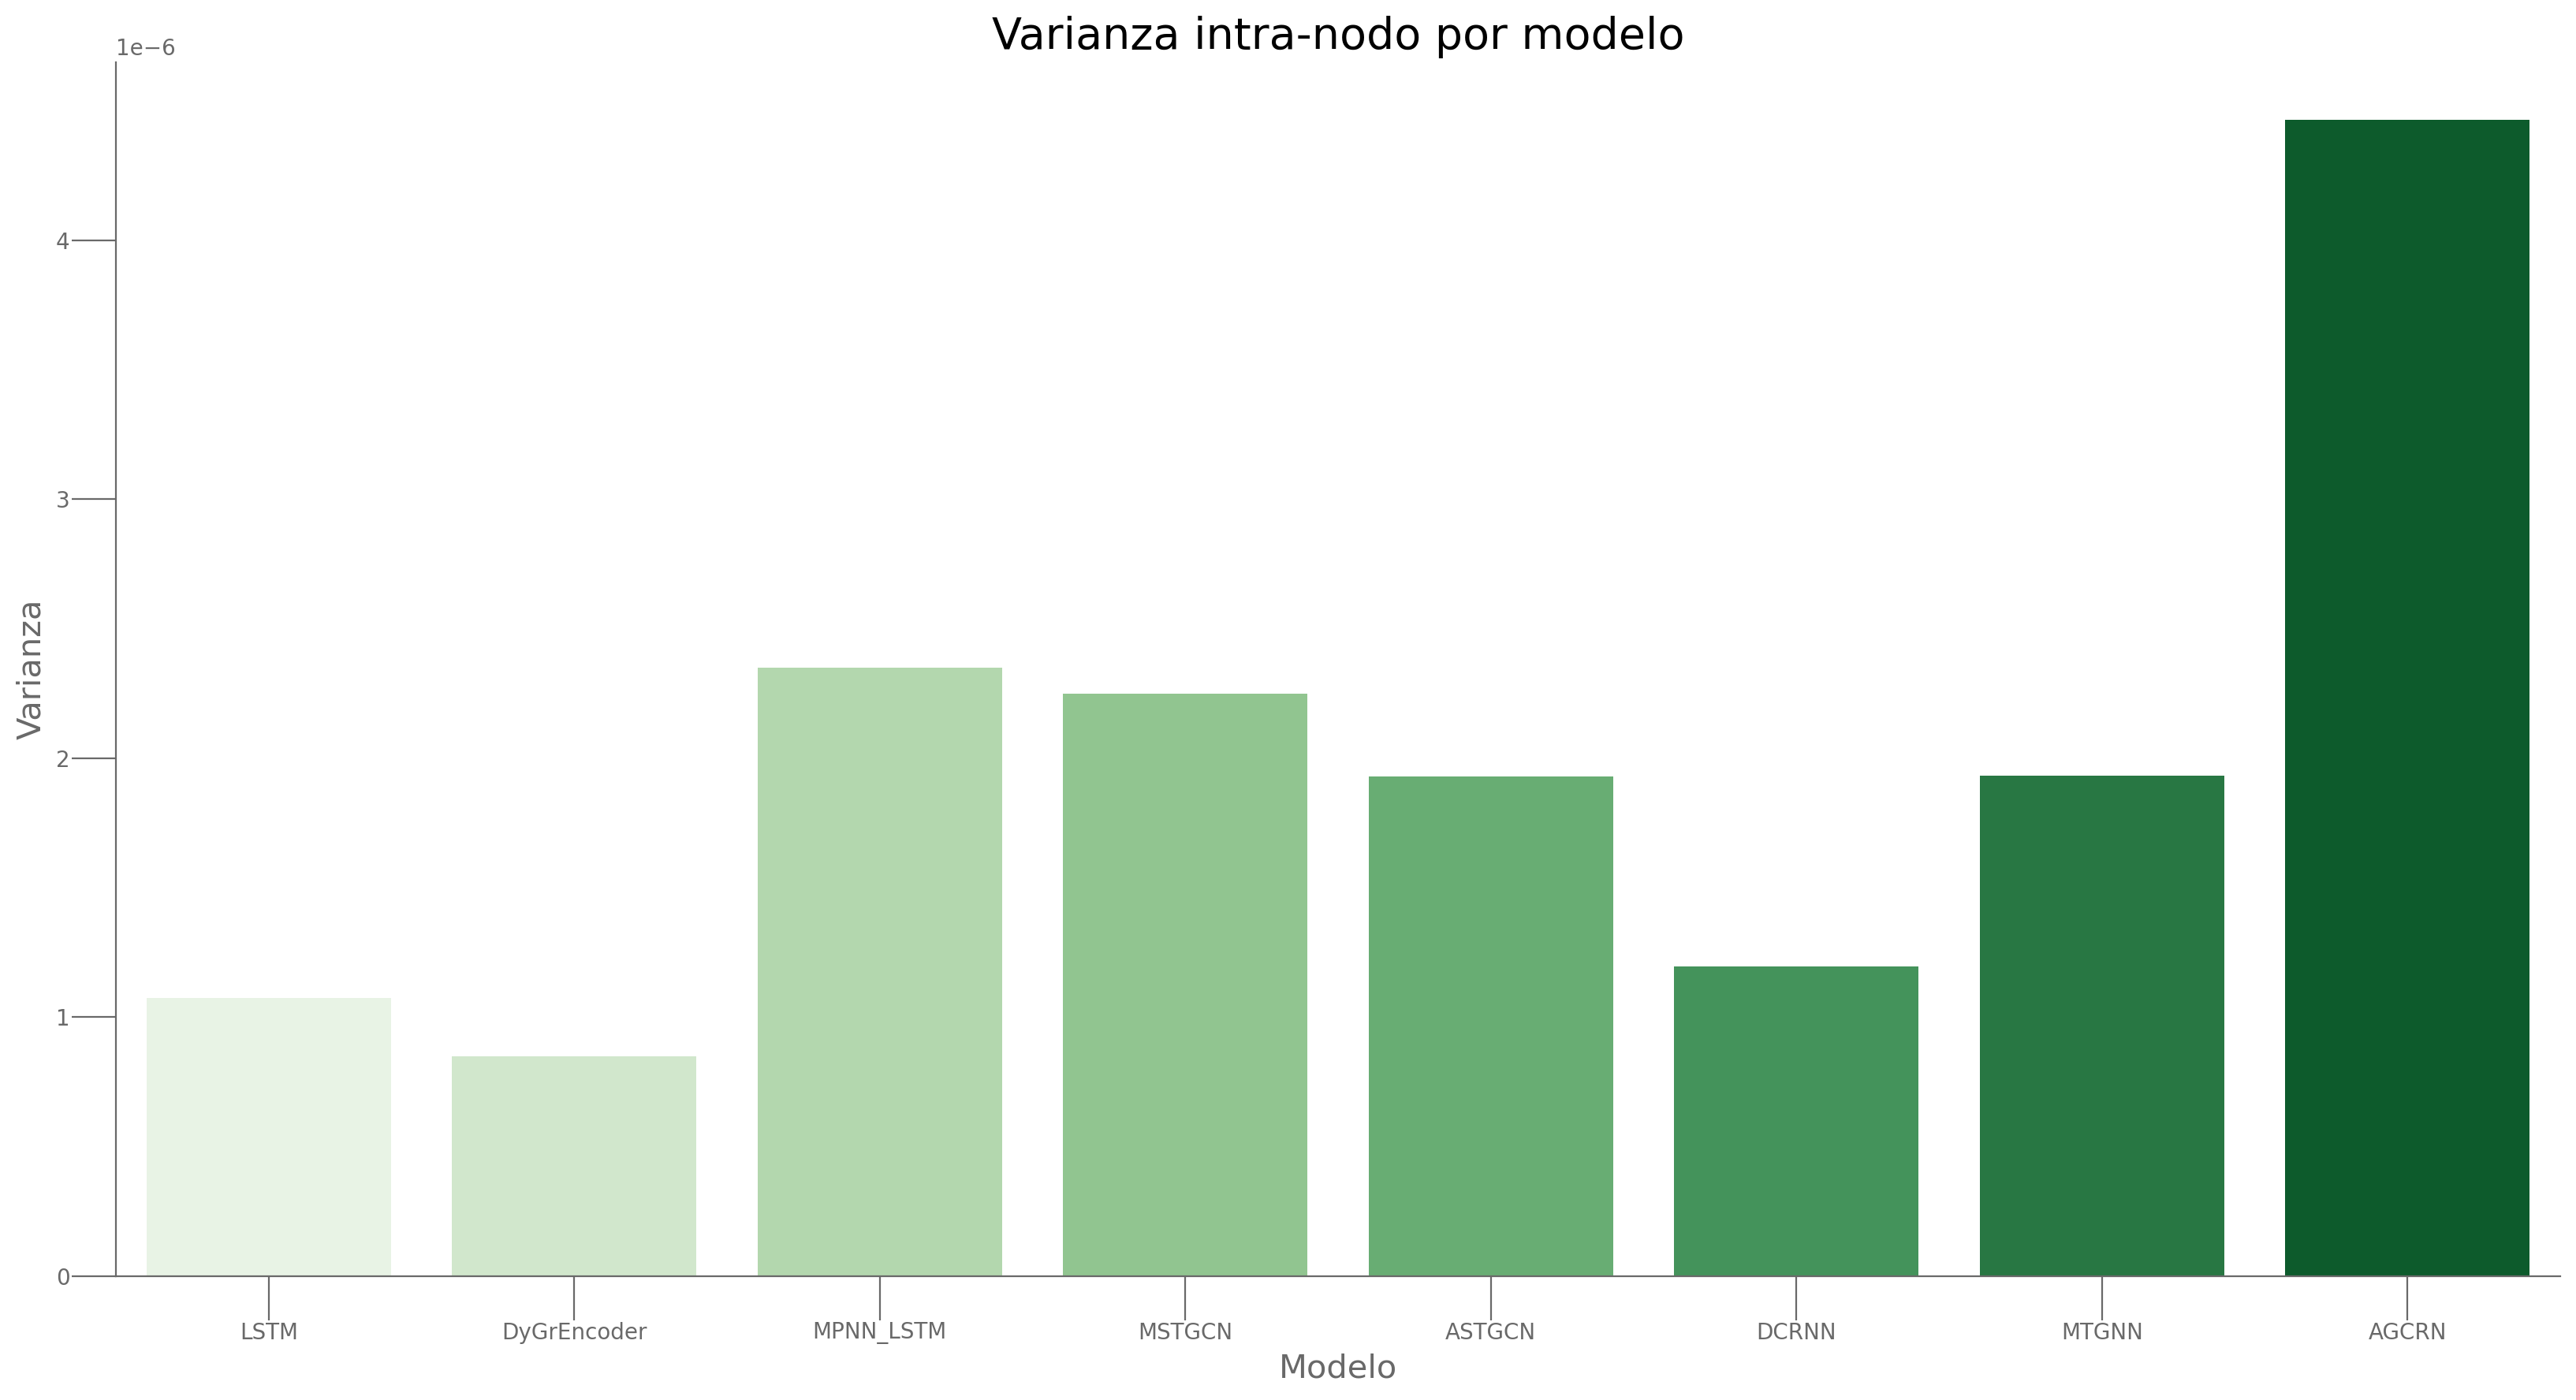

In [31]:
# Identificar el modelo con la menor variabilidad

loss_per_node['Varianza'] = loss_per_node.var(axis=1)

min_var_model = loss_per_node['Varianza'].idxmin()
min_var_value = loss_per_node['Varianza'].min()

print(f'Modelo con la menor variabilidad: {min_var_model} (Varianza: {min_var_value})')

# Crear un gráfico de barras para visualizar la varianza de cada modelo
plt.figure(figsize=(20, 10), dpi=200)
ax = sns.barplot(x=loss_per_node.index, y='Varianza', data=loss_per_node, palette=palette)
format_plot(ax)


plt.title('Varianza intra-nodo por modelo', fontsize=20)
plt.xlabel('Modelo', fontsize=15)
plt.ylabel('Varianza', fontsize=15)
plt.savefig(path_save+f"/variance_per_model_{str.lower(cmap_name)}.png")

### Comparación general clasificación

In [87]:
problem = "clasificacion"
path_problem_results = os.path.join(results_save_path, problem)
print(path_problem_results)

../experimentos_split/results/clasificacion


In [98]:
path_save

'/Users/maguado/Documents/UGR/Master/TFM/memoria/resultados/branch_fault'

In [88]:
df = pd.read_csv(path_problem_results+'/results.csv')
df.sort_values(by='Loss_tst')


,Modelo,Params,Fichero_resultados_experimento,Loss_tst,Loss_eval,Loss_final,Accuracy_eval,Precision_eval,Recall_eval,F1_eval,Accuracy_tst,Precision_tst,Recall_tst,F1_tst
7,MTGNN,"{'gcn_depth': 2, 'conv_channels': 16, 'kernel_...",../experimentos_split/results/clasificacion/aj...,1.064711,1.164019,1.105075,0.731707,0.584593,0.679561,0.621524,0.843373,0.673333,0.746667,0.699105
5,MSTGCN,"{'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_...",../experimentos_split/results/clasificacion/aj...,1.115873,1.170089,1.019408,0.746667,0.699744,0.720493,0.707039,0.809524,0.731190,0.720881,0.717359
2,LSTM_NOBATCH,"{'Hidden Size': 150, 'Layers': 2}",../experimentos_split/results/clasificacion/aj...,1.160608,1.194841,1.076455,0.706667,0.666084,0.685025,0.667648,0.738095,0.688172,0.677798,0.681843
1,LSTM_BATCH,"{'Hidden Size': 150, 'Layers': 1}",../experimentos_split/results/clasificacion/aj...,1.163377,1.213140,1.075731,0.671875,0.630667,0.671140,0.635028,0.765625,0.705541,0.699405,0.698988
4,DyGrEncoder,"{'aggr': 'mean', 'conv': 2, 'lstm': 1, 'lstm_o...",../experimentos_split/results/clasificacion/aj...,1.278305,1.244017,1.019157,0.626667,0.523039,0.498103,0.504885,0.630952,0.586096,0.576328,0.575000
3,AGCRN,"{'hidden': 50, 'Embedding': 5, 'K': 2}",../experimentos_split/results/clasificacion/aj...,1.344170,1.293829,1.254052,0.583333,0.399306,0.481816,0.421265,0.547619,0.327039,0.495517,0.389881
0,MPNN_LSTM,"{'Hidden Size': 64, 'Dropout': 0.2}",../experimentos_split/results/clasificacion/aj...,1.348738,1.286855,1.270143,0.600000,0.438630,0.498128,0.435153,0.535714,0.338182,0.475517,0.388172
6,DCRNN,{'hidden': 60},../experimentos_split/results/clasificacion/aj...,1.365779,1.297018,1.285657,0.600000,0.438603,0.498128,0.418954,0.547619,0.327039,0.495517,0.389881
8,ASTGCN,"{'nb_block': 2, 'nb_chev_filter': 4, 'nb_time_...",NaN,1.401756,1.336499,1.308687,0.573171,0.324919,0.480645,0.381737,0.493976,0.282857,0.469732,0.347118


In [91]:
df.set_index("Modelo", inplace=True)

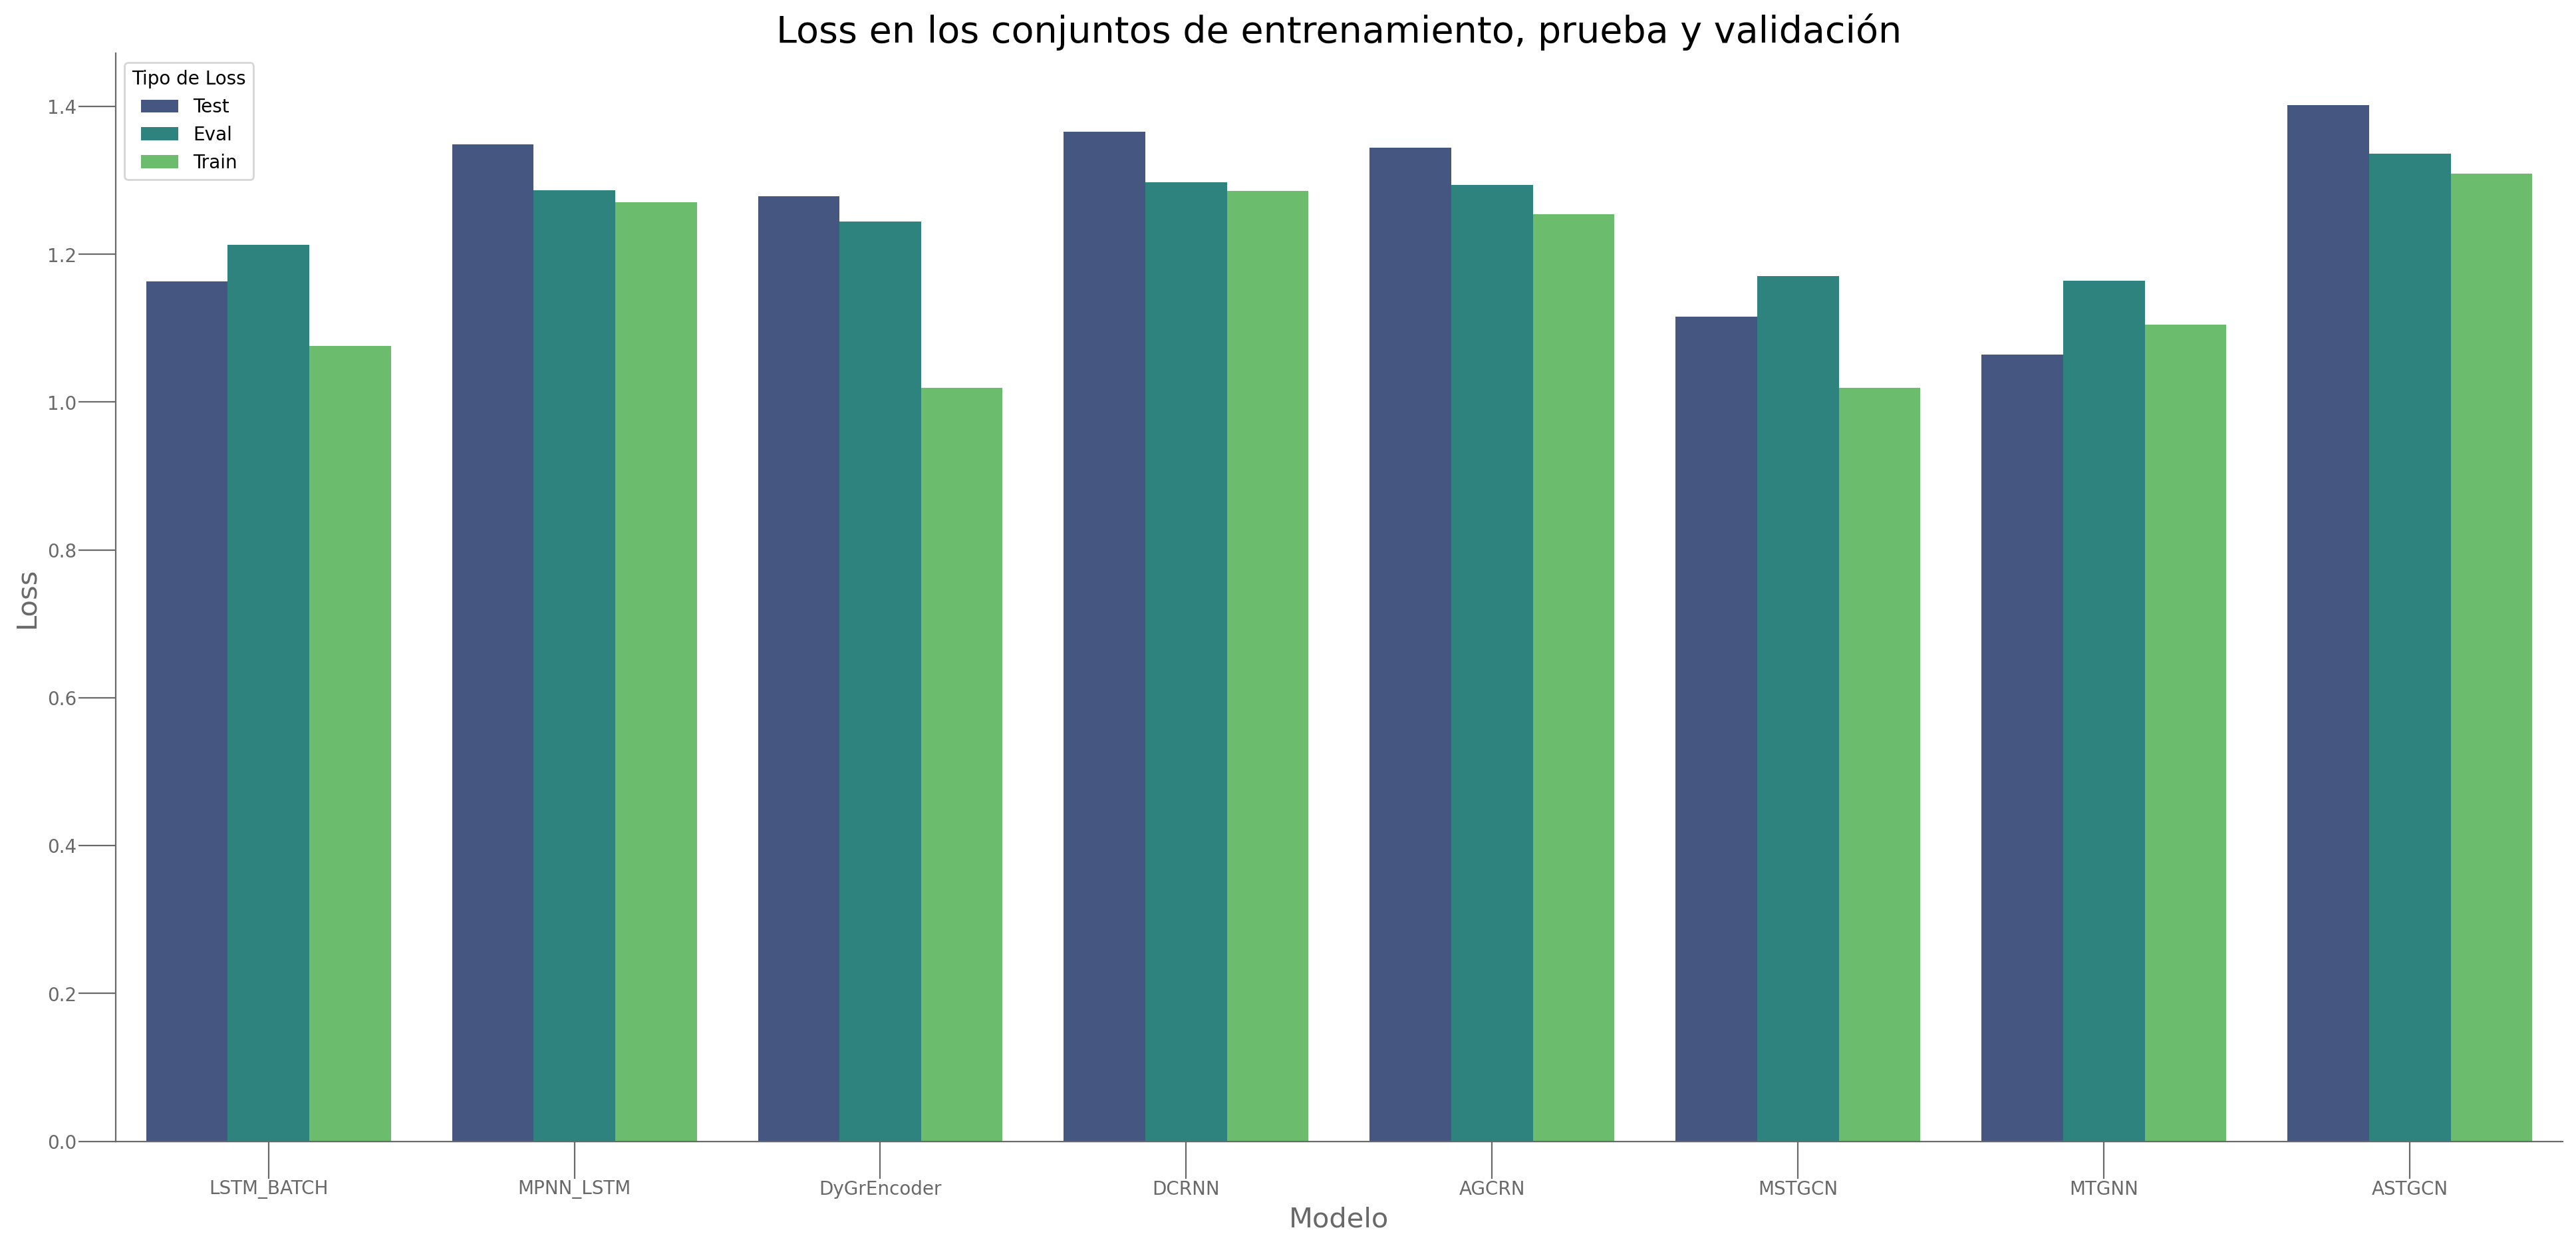

In [97]:
# Seleccionar los modelos deseados
df_p = df.loc[["LSTM_BATCH", "MPNN_LSTM", "DyGrEncoder", "DCRNN", "AGCRN", "MSTGCN", "MTGNN", "DCRNN", "ASTGCN"]]

# Renombrar las columnas para las pérdidas
df_p = df_p.rename(columns={'Loss_tst': 'Test', 'Loss_eval': 'Eval', "Loss_final":"Train"})

# Convertir el DataFrame a formato long para las pérdidas
df_long_loss = pd.melt(df_p.reset_index(), id_vars=['Modelo'], value_vars=['Test', 'Eval', "Train"], 
                       var_name='Tipo de Loss', value_name='Valor')

cmap_name ="viridis"
cmap=cmap_name
if cmap_name == "rose":
    n_colors = len(df_long_loss['Tipo de Loss'].unique())  # Asumiendo que tienes un df llamado df_long_loss
    palette = [to_hex(cmap(i / n_colors)) for i in range(n_colors)]
else:
    palette = cmap

    
plt.figure(figsize=(20, 10), dpi=200)
ax = plt.gca()
sns.barplot(x='Modelo', y='Valor', data=df_long_loss,hue='Tipo de Loss', ax=ax, palette=palette)
ax.set_xlabel('Modelo', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
plt.title('Loss en los conjuntos de entrenamiento, prueba y validación', fontsize=20)
#ax[1].set_xticklabels(target_names, rotation=45)  # Asegurando que los nombres estén rotados si son largos
format_plot(ax)
plt.tight_layout(pad=3)
plt.savefig(path_save+f"/loss_train_test_eval_{str.lower(cmap_name)}.png")

In [ ]:
models_2 = ["AGCRN", "DyGrEncoder", "MSTGCN", "MPNN_LSTM", "DCRNN", "MTGNN", "EvolveGCN"]
print("Problema: ", problem)
p_es = "cortocircuito de rama"
path = f"/Users/maguado/Documents/UGR/Master/TFM/memoria/resultados/{problem}"
for m in models_2:
    print("Procesando modelo: ", m)
    models_analysis = [ m,"LSTM_NOBATCH"] if m != "MSTGCN" else [m, "ASTGCN", "LSTM_NOBATCH"]
    predictions = {}
    real = {} #Si todos los modelos van sin batch, no hace falta guarsar todos, pero lo ponemos por si acaso
    for model_name in models_analysis:
        print("\n\nModelo: ", model_name)
        trainer = process_model(model_name, path_problem_results, dataset, dataloader_params, problem)
        _,_,_,preds, reals = trainer.test()
        predictions[model_name] = preds
        real[model_name] = reals

    from importlib import reload

    utils_graph =reload(utils.utils_graph)
    from utils.utils_graph import plot_predictions, plot_multiple_models
    

    predictions_list= [value for value in predictions.values()]
    real_list = [value for value in real.values()]
    num_situations_test = int(len(trainer.loader['test'])/n_div_gt)

    fig = plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=2, n_div=n_div_gt, problem=p_es, names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])
    plt.savefig(path + f"/{m}_2.png")
    plt.show()

    fig = plot_multiple_models(predictions_list, real_list[0], n_target=dataset.targets[0].shape[1], n_situation=7, n_div=n_div_gt, problem=p_es, names_models = models_analysis, info_situation = loader.info_problem[-num_situations_test:])
    plt.savefig(path + f"/{m}_7.png")
    plt.show()